##### top

# This ntb looks at how reliability changes across time and answers the question of how many days are necessary to reliably estimate reliability of a task or a trait to be stable

The motivation is that people are changing every day and many other factors come into play when coming for an experiment and measuring certain aspects and traits over several days. The obvious factors like attention, mood, fatigue, lack of sleep, stress, etc. may significantly affect results of an experiment and when behavioural measures are not collected on the same day as neuronal data, these effects can have significant impact on obtained correlations and measures.

Therefore, here we use longitudinal FMP task that was collected on 6 different days separated by minimum a day and maximum 6 weeks. Every visit had a different form (there are in total 6 forms, A-F) and the order of form was randomised across N=206 participants that successfully finished the task.

In addition, we use data from the rest of the battery to show effects within a day, few days a part and months apart for the CFMT task. Lastly we use the entire battery to look at longitudinal effects.

Note
--
The FMP data and the task are not yet published and therefore, only the minimal part of the data is present to reproduce these results. If you are to use this data before the corresponding paper is published, please cite the data and/or this article.


---
Content
--
* [Load data and code](#Load-data-and-code)
* [Longitudinal FMP](#FMP)
    * [Remove outliers - 2SD on difference for all the combinations](#Remove-outliers---2SD-on-difference-for-all-the-combinations)
        * [Days 3 vs 5 without outliers on all forms](#Days-3-vs-5-without-outliers-on-all-forms)
        * [Concatenated days 3&5 with concatenated days 2&4 without outliers on all forms](#Concatenated-days-3&5-with-concatenated-days-2&4-without-outliers-on-all-forms)
        * [Concatenated days 1&3&5 with concatenated days 2&4&6 without outliers on all forms](#Concatenated-days-1&3&5-with-concatenated-days-2&4&6-without-outliers-on-all-forms)

* [CFMT within-day and far apart in time comparison](#CFMT-within-day-and-far-apart-in-time-comparison)
    * [Remove outliers on CFMT 2SD](#Remove-outliers-on-CFMT-2SD)
        * [Do subsampling of CFMT subjects without outliers](#Do-subsampling-of-CFMT-subjects-without-outliers)
    * [Are CFMT curves significantly different?](#Are-CFMT-curves-significantly-different?)
    * [Statistical testing of pooled curves vs test-retest](#Statistical-testing-of-pooled-curves-vs-test-retest)
* [Reliability stability across days - all tasks](#Reliability-stability-across-days---all-tasks)
* [Article Figure](#CanD)


# Load data and code
[top](#top)

In [1]:
import os, sys
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

def find_closest_key(value, dic_tasks_results):
    # Find the key with the closest defined_C to the given value
    closest_key = min(dic_tasks_results.keys(), key=lambda k: abs(dic_tasks_results[k][80]['computed_C'] - value))
    return closest_key


# Importing module for functions
functions_modul =  os.path.join("../", "Code", "functions")
sys.path.insert(0, functions_modul)

from reliability_functions import check_df_get_numbers, extract_data, calculate_reliability_between_two_groups, get_true_correlation
from plot_functions import label_correlation, calculate_reliability_between_two_groups_scatterplots, sharey_ax
from data_processing_functions import process_and_concatenate_all_tasks
from composite_measures_functions import calculate_LDI_REC, calculate_SCAP_Cowan_k, calculate_all_PGNG_measures

# Define path and name
csv_clean_data_path_FMP = "../Data/cleaned_csv_FMP"
csv_clean_data_path = "../Data/cleaned_CSV" 
path_results = "../Data/results"
path_figures = "./"


In [2]:
def human_label(x):
    if 'car' in x or 'emotion' in x:
        return x.replace('_', ' ').replace('ll', 'l').title()
    elif x == "VET_birds_planes_leaves":
        return "VET"
    elif x == "nback_concat_d_prime" or x == "nback_concat_level2_d_prime":
        return "N Back d'"
    elif x == "n_back":
        return "N Back"
    elif x == "CFMT_origFmonth":
        return "CFMT"#"CFMT months apart"
    elif "Aus" in x:
        return x.replace('Aus2F2_', '').replace('AusF_', '').replace('_', ' ')
    else:
        return x.replace('_', ' ')

In [3]:
def clean_outliers(df_temp, cleaning_conditions):
    # go over all conditions of cleaning
    for diff_c, perf_c in cleaning_conditions:
        # copy the df to be able to clean it
        df_temp_cleaned = df_temp.copy()
        
        # define condition
        condition = f'diff:{diff_c}, perf:{perf_c}'
        print(condition)
        
        # define outliers that we want to drop on accuracy
        if perf_c is not None:
            # check if it's SD or %
            if 'SD' in perf_c:
                # find the SD and select the SD
                std_thr_acc = float(perf_c.strip('SD'))
                # add label
                condition += '_bottom'
                           
                for form in ["original", "repetition"]:        
                    # compute the mean, use the original dataset and not the one that will already be partially cleaned
                    tmp_series = df_temp.loc[df_temp["form"]==form].groupby(['userID']).correct.mean()
                    mu_acc = tmp_series.mean() #df_temp['correct'].mean()
                    std_acc = tmp_series.std() #df_temp.groupby(['userID']).correct.mean().std()
                    outliers_acc = set(tmp_series[tmp_series<mu_acc-std_acc*std_thr_acc].dropna().index)
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
            
            elif '%' in perf_c:
                # drop the perf_c percent of the scores
                std_thr_acc = float(perf_c.strip('%'))/100
                for form in ["original", "repetition"]:        
                    # take the n smallest scores where n is proportional to the threshold
                    outliers_acc = tmp_series.nsmallest(int(np.round(len(tmp_series)*std_thr_acc))).index
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
                    
            else:
                raise ValueError(f'Provided value cannot be processed: {perf_c}')
        
        # there is no else because if it is None, then we are not cleaning which means that we continue with the original dataset
                
        
        # define outliers that we want to drop on score difference between visits
        if diff_c is not None:            
            # compute the score difference
            tmp_score_diff = df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()

            # check if it's SD or %
            if 'SD' in diff_c:
                std_thr = float(diff_c.strip('SD'))
                # drop participants whose difference in score on first and second step is large
                mu = tmp_score_diff.mean()[0]
                std = tmp_score_diff.std()[0]
                outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
            elif '%' in diff_c:
                # drop the perf_c percent of the scores
                std_thr = float(diff_c.strip('%'))/100
                
                # take the n larges differences in scores where n is proportional to the threshold
                outliers = tmp_score_diff.abs().nlargest(int(np.round(len(tmp_score_diff)*std_thr)), 'correct').index
                # drop the outliers form the cleaned dataset
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
                
            print(f'Dropping {len(outliers)} outliers for score difference')

    return df_temp_cleaned

def calculate_t_test(orig, rep, task, significant_learning, significance_threshold=0.01):
    # do scipy stats
    T, p = scipy.stats.ttest_ind(orig, rep, nan_policy='omit')
    # do pingouin stats
    df_pg = pg.ttest(orig, rep, paired=False)
    # add label
    df_pg["task"] = task
    
    # check that they're close
    assert np.isclose(p, df_pg['p-val'].values[0])
    
    print(f"T={T}, p={p}")
    print(df_pg, '\n')

    # check significance levels
    if p < 0.001:
        print(f'***     --> {task}')
        df_pg["star_gazing"] = '***'
        if p < significance_threshold:
            significant_learning.append(task)
    elif p < 0.01:
        print(f'**     --> {task}')
        df_pg["star_gazing"] = '**'
        if p < significance_threshold: 
            significant_learning.append(task)
    elif p < 0.05:
        print(f'*     --> {task}')
        df_pg["star_gazing"] = '*'
        if p < significance_threshold:
            significant_learning.append(task)
    
    print()
    return T, p, significant_learning, df_pg




## FMP
[top](#top)

Reliability of longitudinal FMP.  For this analysis, only trials with unmorphed face as a target were used.

In [4]:
all_days_df = []

for i in range(1,7):
    tmp = None

    day=f"day{i}"
    # check if we have any files
    if os.path.exists(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv")):
        tmp = pd.read_csv(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv"))

        all_days_df.append(tmp)

# concatenate them
df_plot_longitudinal = pd.concat(all_days_df)
print("Num of participants: ", len(df_plot_longitudinal['userID'].unique()))

Num of participants:  206


## Remove outliers - 2SD on difference for all the combinations
[top](#top)

The cleaning should be done on all pairs: difference in score on days 3 and 5, then 35 and 24, and also 135 and 246, take a union of all the outliers and remove them.


In [5]:
outliers_longitudinal = []
std_thr = 2

for d1, d2 in [([3], [5]), ([3,5], [2,4]), ([1,3,5], [2,4,6])]:
    
    # compute differences
    score_diff_FMP = (df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d1)].groupby(['userID']).mean() - df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d2)].groupby(['userID']).mean()).reset_index()

    mean = score_diff_FMP['correct_flt'].mean()
    std = score_diff_FMP['correct_flt'].std()

    # get subjects who are outliers
    outliers_tmp = score_diff_FMP.loc[(score_diff_FMP["correct_flt"] > mean+std_thr*std)|(score_diff_FMP["correct_flt"] < mean-std_thr*std), "userID"].values
    outliers_longitudinal += list(outliers_tmp)

    # num of subjects
    print(len(outliers_tmp))
    
print(f'unique total: {len(set(outliers_longitudinal))}')

10
9
6
unique total: 23


### Days 3 vs 5 without outliers on all forms
[top](#top)

In [6]:
# get subjects who are not outliers
not_outliers_FMP_long_all_days = set(df_plot_longitudinal.userID)-set(outliers_longitudinal)
# num of subjects
N_FMP_long_nooutliers_all_days = len(not_outliers_FMP_long_all_days)
assert N_FMP_long_nooutliers_all_days == 206-23
print(f'Out of {df_plot_longitudinal["userID"].unique().size} we take {N_FMP_long_nooutliers_all_days}, we drop {len(set(outliers_longitudinal))}')


## Day 3
# select only relevant part of the df
df_day3 = df_plot_longitudinal.loc[(df_plot_longitudinal['visit']==3)&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
df_day3 = df_day3.groupby('userID').sample(df_day3['userID'].value_counts().min(), random_state=0)

## Day 5
# select only relevant part of the df
df_day5 = df_plot_longitudinal.loc[(df_plot_longitudinal['visit']==5)&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
df_day5 = df_day5.groupby('userID').sample(df_day5['userID'].value_counts().min(), random_state=0)


# select only the non-outliers
df_day3_nooutliers = df_day3.loc[df_day3["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)
df_day5_nooutliers = df_day5.loc[df_day5["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)


## extract data
# max number of trials
total_n_trials_day3_nooutliers = check_df_get_numbers(df_day3_nooutliers, N_FMP_long_nooutliers_all_days)
# extract the data
all_trials_reshaped_target0_day3_nooutliers = extract_data(df_day3_nooutliers, total_n_trials_day3_nooutliers, measure="correct_flt")


# max number of trials
total_n_trials_day5_nooutliers = check_df_get_numbers(df_day5_nooutliers, N_FMP_long_nooutliers_all_days)
# extract the data
all_trials_reshaped_target0_day5_nooutliers = extract_data(df_day5_nooutliers, total_n_trials_day5_nooutliers, measure="correct_flt")



## Days 3 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([3,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day3and5_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day3and5_concat_nooutliers = extract_data(df_short, total_n_trials_day3and5_concat_nooutliers, measure="correct_flt")




Out of 206 we take 183, we drop 23
Total number of trials is 129.
Total number of trials is 129.
259
Total number of trials is 259.


In [7]:
# how many samples we want to correlate
n_repeats = 10**3

# do day 3 vs 5
array_corr_fxn_day3vs5_nooutliers, n_trials_list_day3vs5_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3_nooutliers, all_trials_reshaped_target0_day5_nooutliers, total_n_trials_day3_nooutliers+total_n_trials_day5_nooutliers, step=6)

# and concat
array_corr_fxn_day3and5_concat_nooutliers, n_trials_list_day3and5_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3and5_concat_nooutliers, all_trials_reshaped_target0_day3and5_concat_nooutliers, total_n_trials_day3and5_concat_nooutliers, step=6)


Taking random trials from the two different arrays.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:664: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 9.85 s which is 0.16 min.
Process took: 10.51 s which is 0.18 min.


### Concatenated days 3&5 with concatenated days 2&4 without outliers on all forms
[top](#top)

In [8]:
## Days 2 and 4
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,4]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day2and4_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day2and4_concat_nooutliers = extract_data(df_short, total_n_trials_day2and4_concat_nooutliers, measure="correct_flt")


## Days 2, 3, 4 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,3,4,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day2345_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day2345_concat_nooutliers = extract_data(df_short, total_n_trials_day2345_concat_nooutliers, measure="correct_flt")



259
Total number of trials is 259.
521
Total number of trials is 521.


In [9]:
# do 3&5 vs 2&4

array_corr_fxn_day35vs24_nooutliers, n_trials_list_day35vs24_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3and5_concat_nooutliers, all_trials_reshaped_target0_day2and4_concat_nooutliers, 2*total_n_trials_day2and4_concat_nooutliers, step=8)

# and three+five concat
array_corr_fxn_day2345_concat_nooutliers, n_trials_list_day2345_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day2345_concat_nooutliers, all_trials_reshaped_target0_day2345_concat_nooutliers, total_n_trials_day2345_concat_nooutliers, step=16)


Taking random trials from the two different arrays.
Process took: 19.19 s which is 0.32 min.
Process took: 10.51 s which is 0.18 min.


### Concatenated days 1&3&5 with concatenated days 2&4&6 without outliers on all forms
[top](#top)

In [10]:
## Days 1 and 3 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([1,3,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day135_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day135_concat_nooutliers = extract_data(df_short, total_n_trials_day135_concat_nooutliers, measure="correct_flt")


## Days 2 and 4 and 6
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,4,6]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day246_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day246_concat_nooutliers = extract_data(df_short, total_n_trials_day246_concat_nooutliers, measure="correct_flt")


## All days
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_alldays_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_alldays_concat_nooutliers = extract_data(df_short, total_n_trials_alldays_concat_nooutliers, measure="correct_flt")


389
Total number of trials is 389.
389
Total number of trials is 389.
786
Total number of trials is 786.


In [11]:
# how many samples we want to correlate
n_repeats = 10**3


# do 135 vs 246
array_corr_fxn_day135vs246_nooutliers, n_trials_list_day135vs246_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day135_concat_nooutliers, all_trials_reshaped_target0_day246_concat_nooutliers, total_n_trials_day135_concat_nooutliers+total_n_trials_day246_concat_nooutliers, step=16)

# and all days concat_nooutliers
array_corr_fxn_alldays_concat_nooutliers, n_trials_list_alldays_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_alldays_concat_nooutliers, all_trials_reshaped_target0_alldays_concat_nooutliers, total_n_trials_alldays_concat_nooutliers, step=15)


Taking random trials from the two different arrays.
Process took: 17.03 s which is 0.28 min.
Process took: 22.75 s which is 0.38 min.


### Plot
[top](#top)

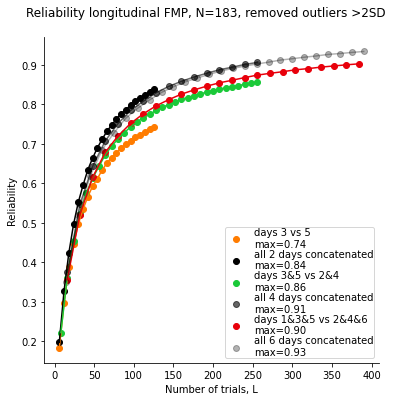

In [12]:
palette = sns.color_palette("bright", n_colors=4, as_cmap=False)
colour_day3and5 = palette[1]
colour_day35and24 = palette[2]
colour_day135and246 = palette[3]

fig, ax = plt.subplots(1,1, figsize=(6,6), sharey=True)

ax.scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'days 3 vs 5\nmax={np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1).max():.2f}', color=colour_day3and5)
ax.plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)

# add the full concatenated 2 forms
ax.scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'all 2 days concatenated\nmax={np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1).max():.2f}', color='k')
ax.plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


####################
ax.scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'days 3&5 vs 2&4\nmax={np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1).max():.2f}', color=colour_day35and24)
ax.plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)

# add the full concatenated 4 forms
ax.scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'all 4 days concatenated\nmax={np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1).max():.2f}', color='k', alpha=0.6)
ax.plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


####################
ax.scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'days 1&3&5 vs 2&4&6\nmax={np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1).max():.2f}', color=colour_day135and246)
ax.plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)

# add the full concatenated 6 forms
ax.scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'all 6 days concatenated\nmax={np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1).max():.2f}', color='k', alpha=0.3)
ax.plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)

ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

# ax.set_title(f'Day 3 and 5\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day3}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day5}')
# ax.set_title(f'Day 3&5 and 2&4\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day2345_concat_nooutliers}, n$_{{\mathrm{{day35}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day2and4_concat_nooutliers}')
# ax.set_title(f'All days\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_alldays_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day135_concat_nooutliers}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day246_concat_nooutliers}')


sns.despine()

# plt.suptitle(f'Reliability FMP, unmorphed target only, Day 3 and 5\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day3}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day5}')
plt.suptitle(f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', y=.95)
plt.show()

#### Calculate significance

In [13]:
# compute all missing arrays
step = 16

dic_true_rel_FMP_longitudinal = {}

for i, (label, day_f, day_s, total_ntrials) in enumerate([
    ('1d', all_trials_reshaped_target0_day3_nooutliers, all_trials_reshaped_target0_day5_nooutliers, total_n_trials_day5_nooutliers),
    ('2d', all_trials_reshaped_target0_day3and5_concat_nooutliers, all_trials_reshaped_target0_day2and4_concat_nooutliers, total_n_trials_day3and5_concat_nooutliers),
    ('3d', all_trials_reshaped_target0_day135_concat_nooutliers, all_trials_reshaped_target0_day246_concat_nooutliers, total_n_trials_day135_concat_nooutliers),
]):
    
    # do first batch
    array_corr_f, n_list_f = calculate_reliability_between_two_groups(day_f, day_f, total_ntrials, step=step)
    # do second batch
    array_corr_s, n_list_s = calculate_reliability_between_two_groups(day_s, day_s, total_ntrials, step=step)
    # do first vs second, compute it only until the max
    array_corr_fvss, n_list_fvss = calculate_reliability_between_two_groups(day_f, day_s, total_ntrials, step=step)

    # compute true correlation
    true_rel = get_true_correlation(np.nanmean(array_corr_fvss, axis=1),
                     np.nanmean(array_corr_f, axis=1), 
                     np.nanmean(array_corr_s, axis=1))
    
    # check that really all lists are the same
    assert (n_list_f==n_list_s).all() and (n_list_f==n_list_fvss).all()
    # save
    dic_true_rel_FMP_longitudinal[label]= {
        'true_rel': true_rel,
        'n_trials_list': n_list_f,
    }
    
dic_true_rel_FMP_longitudinal

Process took: 1.72 s which is 0.03 min.
Process took: 1.81 s which is 0.03 min.
Taking random trials from the two different arrays.
Process took: 1.79 s which is 0.03 min.
Process took: 4.51 s which is 0.08 min.
Process took: 3.96 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 3.83 s which is 0.06 min.
Process took: 7.15 s which is 0.12 min.
Process took: 7.31 s which is 0.12 min.
Taking random trials from the two different arrays.
Process took: 6.98 s which is 0.12 min.


{'1d': {'true_rel': array([0.87686829, 0.88042634, 0.87943726, 0.88107808]),
  'n_trials_list': array([16, 32, 48, 64])},
 '2d': {'true_rel': array([0.94216431, 0.94059282, 0.94037638, 0.94107688, 0.93989092,
         0.94183794, 0.94250892, 0.94180872]),
  'n_trials_list': array([ 16,  32,  48,  64,  80,  96, 112, 128])},
 '3d': {'true_rel': array([0.96892153, 0.96894922, 0.96667496, 0.96864498, 0.96571728,
         0.96651014, 0.96527339, 0.96700661, 0.96639492, 0.96730812,
         0.96701485, 0.96676148]),
  'n_trials_list': array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192])}}

In [14]:
# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error = pickle.load(f)
    
# define the L
index = 1
for day in ['1d', '2d', '3d']:
    # get the value
    true_rel = dic_true_rel_FMP_longitudinal[day]['true_rel'][index]
    
    print(f"True reliability for FMP {day} at L={dic_true_rel_FMP_longitudinal[day]['n_trials_list'][index]}: {true_rel:.3f}")
    
    # find C closest to the value
    closest_C = find_closest_key(33.7, dic_reliability_error)
    
    # take what is computed for L=20
    r_xy_array = dic_reliability_error[closest_C][80]['r_xy_array'][:,1]

    lower1 = np.percentile(r_xy_array, 1)
    lower2 = np.percentile(r_xy_array, 5)
    upper1 = np.percentile(r_xy_array, 99)
    upper2 = np.percentile(r_xy_array, 95)
    
    print(lower1, lower2)

    if true_rel < lower1 or true_rel > upper1:
        print(f"** for {day}, {true_rel} < {lower1} (1%) or {true_rel} > {upper1} (99%)")
    elif true_rel < lower2 or true_rel > upper2:
        print(f"* for {day}, {true_rel} < {lower2} (5%) or {true_rel} > {upper2} (95%)")
    else:
        print('not significant')

True reliability for FMP 1d at L=32: 0.880
0.7453194698539479 0.8235600668772528
not significant
True reliability for FMP 2d at L=32: 0.941
0.7453194698539479 0.8235600668772528
not significant
True reliability for FMP 3d at L=32: 0.969
0.7453194698539479 0.8235600668772528
not significant


In [15]:
# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_largestL_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error_FMP = pickle.load(f)
    
    
for day in [1, 2, 3]:
    # get the value
    true_rel = dic_true_rel_FMP_longitudinal[f'{day}d']['true_rel'][index]
    
    print(f"\nTrue reliability for FMP {day}d at L={dic_reliability_error_FMP[f'FMP_longitudinal_{day}d_real'][day*2*128]['n_trials_list_orig'][0]}: {true_rel:.3f}")
    
    # take what is computed for largest L
    r_xy_array = dic_reliability_error_FMP[f'FMP_longitudinal_{day}d_real'][day*2*128]['r_xy_array']

    lower1 = np.percentile(r_xy_array, 1)
    lower2 = np.percentile(r_xy_array, 5)
    upper1 = np.percentile(r_xy_array, 99)
    upper2 = np.percentile(r_xy_array, 95)
    
    print(f'Lower bounds for 1st percentile and 5th percentile: {lower1:.3f}, {lower2:.3f}')

    if true_rel < lower1 or true_rel > upper1:
        print(f"** for {day}d, {true_rel} < {lower1} (1%) or {true_rel} > {upper1} (99%)")
    elif true_rel < lower2 or true_rel > upper2:
        print(f"* for {day}d, {true_rel} < {lower2} (5%) or {true_rel} > {upper2} (95%)")
    else:
        print('not significant')


True reliability for FMP 1d at L=64: 0.880
Lower bounds for 1st percentile and 5th percentile: 0.953, 0.966
** for 1d, 0.8804263388545056 < 0.9529143401086398 (1%) or 0.8804263388545056 > 1.0419441953229887 (99%)

True reliability for FMP 2d at L=128: 0.941
Lower bounds for 1st percentile and 5th percentile: 0.976, 0.981
** for 2d, 0.9405928232067555 < 0.9756765471628392 (1%) or 0.9405928232067555 > 1.0253999743086646 (99%)

True reliability for FMP 3d at L=192: 0.969
Lower bounds for 1st percentile and 5th percentile: 0.983, 0.987
** for 3d, 0.9689492198484266 < 0.9825223663758934 (1%) or 0.9689492198484266 > 1.015757812800907 (99%)


## CFMT within-day and far apart in time comparison
[top](#top)

### Remove outliers on CFMT 2SD
[top](#top)

The idea is that if people have very different score on the first and the second visit, they then drive the correlations to low values. Therefore, we want to remove this bias and look again at the same measures, i.e. Aus vs F version of CFMT, first visits of participants and then compare between having done the CFMT on separate days and on the same day.

#### Compare Aus and F first visit only, same day
[top](#top)

That means, only the second dataset and only first time visitors

In [16]:
# load participants per each of the 4 forms
f2 = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F2-cleaned_data.csv"), usecols=['userID']).userID)
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
aus2 = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus2-cleaned_data.csv"), usecols=['userID']).userID)
aus = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-cleaned_data.csv"), usecols=['userID']).userID)

# select participants from the second who do not have the first to include them
take_aus2 = set(aus2) - set(aus)  # take from aus 2 everyone who does not have aus 1
take_f2 = set(f2) - set(f)  # take from female 2 everyone who does not have female 1
# overlap
first_time_subjects = list(take_aus2&take_f2)#&set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID))

print(f"""Number of participants:
First F: {len(f)}
First Aus: {len(aus)}
Second F: {len(f2)}
Second Aus: {len(aus2)}

Number of participants from the second that do not have the first:
Aus: {len(take_aus2)}
F: {len(take_f2)}

Overlap: {len(first_time_subjects)}
""")


# df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Aus2 = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_Aus2-cleaned_data.csv'))
df_CFMT_F2 = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F2-cleaned_data.csv'))


# take only the full data
# df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Aus2 = df_CFMT_Aus2[df_CFMT_Aus2["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_F2 = df_CFMT_F2[df_CFMT_F2["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_Aus2F2, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_Aus2F2 = (df_CFMT_Aus2.groupby(['userID']).mean() - df_CFMT_F2.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_Aus2F2['correct'].mean()
std = score_diff_CFMT_Aus2F2['correct'].std()

not_outliers_CFMT_Aus2F2 = score_diff_CFMT_Aus2F2.loc[(score_diff_CFMT_Aus2F2["correct"] <= mean+std_thr*std)&(score_diff_CFMT_Aus2F2["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_Aus2_nooutliers = df_CFMT_Aus2.loc[df_CFMT_Aus2["userID"].isin(not_outliers_CFMT_Aus2F2), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_F2_nooutliers = df_CFMT_F2.loc[df_CFMT_F2["userID"].isin(not_outliers_CFMT_Aus2F2), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_Aus2F2_nooutliers = len(not_outliers_CFMT_Aus2F2)
print(f'After cleaning taking {N_CFMT_Aus2F2_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_Aus2_nooutliers = check_df_get_numbers(df_CFMT_Aus2_nooutliers, N_CFMT_Aus2F2_nooutliers)
total_n_trials_CFMT_F2_nooutliers = check_df_get_numbers(df_CFMT_F2_nooutliers, N_CFMT_Aus2F2_nooutliers)

# extract the data
all_trials_reshaped_CFMT_Aus2_nooutliers = extract_data(df_CFMT_Aus2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers, measure="correct")
all_trials_reshaped_CFMT_F2_nooutliers = extract_data(df_CFMT_F2_nooutliers, total_n_trials_CFMT_F2_nooutliers, measure="correct")


## add concat data
df_CFMT_Aus2F2_concat_nooutliers = pd.concat([df_CFMT_Aus2_nooutliers, df_CFMT_F2_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_Aus2F2_concat_nooutliers = check_df_get_numbers(df_CFMT_Aus2F2_concat_nooutliers, N_CFMT_Aus2F2_nooutliers)
all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers = extract_data(df_CFMT_Aus2F2_concat_nooutliers, total_n_trials_CFMT_Aus2F2_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Aus: 94
Second F: 110
Second Aus: 117

Number of participants from the second that do not have the first:
Aus: 50
F: 49

Overlap: 44

After cleaning taking 42 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [17]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2_nooutliers, all_trials_reshaped_CFMT_F2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers+total_n_trials_CFMT_F2_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers, all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers, total_n_trials_CFMT_Aus2F2_concat_nooutliers, step=8)


# add also each day separately to be able to get true reliability
array_corr_fxn_CFMT_Aus2F2_Aus2_nooutliers, n_trials_list_CFMT_Aus2F2_Aus2_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2_nooutliers, all_trials_reshaped_CFMT_Aus2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers, step=8)
array_corr_fxn_CFMT_Aus2F2_F2_nooutliers, n_trials_list_CFMT_Aus2F2_F2_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_F2_nooutliers, all_trials_reshaped_CFMT_F2_nooutliers, total_n_trials_CFMT_F2_nooutliers, step=8)


Taking random trials from the two different arrays.
Process took: 3.31 s which is 0.06 min.
Process took: 3.43 s which is 0.06 min.
Process took: 1.40 s which is 0.02 min.
Process took: 1.44 s which is 0.02 min.


#### Compare Aus and F first visit only, separate days
[top](#top)

In [18]:
# load participants per each of the 4 forms
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
aus = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-cleaned_data.csv"), usecols=['userID']).userID)

# overlap
first_time_subjects = list(aus&f)#&set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID))

print(f"""Number of participants:
First F: {len(f)}
First Aus: {len(aus)}

Overlap: {len(first_time_subjects)}
""")

# load data
# df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Aus = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_Aus-cleaned_data.csv'))
df_CFMT_F = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F-cleaned_data.csv'))


# take only the full data
# df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Aus = df_CFMT_Aus[df_CFMT_Aus["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_F = df_CFMT_F[df_CFMT_F["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_AusF, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_AusF = (df_CFMT_Aus.groupby(['userID']).mean() - df_CFMT_F.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_AusF['correct'].mean()
std = score_diff_CFMT_AusF['correct'].std()

not_outliers_CFMT_AusF = score_diff_CFMT_AusF.loc[(score_diff_CFMT_AusF["correct"] <= mean+std_thr*std)&(score_diff_CFMT_AusF["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_Aus_nooutliers = df_CFMT_Aus.loc[df_CFMT_Aus["userID"].isin(not_outliers_CFMT_AusF), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_F_nooutliers = df_CFMT_F.loc[df_CFMT_F["userID"].isin(not_outliers_CFMT_AusF), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_AusF_nooutliers = len(not_outliers_CFMT_AusF)
print(f'After cleaning taking {N_CFMT_AusF_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_Aus_nooutliers = check_df_get_numbers(df_CFMT_Aus_nooutliers, N_CFMT_AusF_nooutliers)
total_n_trials_CFMT_F_nooutliers = check_df_get_numbers(df_CFMT_F_nooutliers, N_CFMT_AusF_nooutliers)

# extract the data
all_trials_reshaped_CFMT_Aus_nooutliers = extract_data(df_CFMT_Aus_nooutliers, total_n_trials_CFMT_Aus_nooutliers, measure="correct")
all_trials_reshaped_CFMT_F_nooutliers = extract_data(df_CFMT_F_nooutliers, total_n_trials_CFMT_F_nooutliers, measure="correct")


## add concat data
df_CFMT_AusF_concat_nooutliers = pd.concat([df_CFMT_Aus_nooutliers, df_CFMT_F_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_AusF_concat_nooutliers = check_df_get_numbers(df_CFMT_AusF_concat_nooutliers, N_CFMT_AusF_nooutliers)
all_trials_reshaped_CFMT_AusF_concat_nooutliers = extract_data(df_CFMT_AusF_concat_nooutliers, total_n_trials_CFMT_AusF_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Aus: 94

Overlap: 81

After cleaning taking 77 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [19]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_AusF_nooutliers, n_trials_list_CFMT_AusF_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers, all_trials_reshaped_CFMT_F_nooutliers, total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_AusF_concat_nooutliers, n_trials_list_CFMT_AusF_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_AusF_concat_nooutliers, all_trials_reshaped_CFMT_AusF_concat_nooutliers, total_n_trials_CFMT_AusF_concat_nooutliers, step=8)


# add also each day separately to be able to get true reliability
array_corr_fxn_CFMT_AusF_Aus_nooutliers, n_trials_list_CFMT_AusF_Aus_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers, all_trials_reshaped_CFMT_Aus_nooutliers, total_n_trials_CFMT_Aus_nooutliers, step=8)
array_corr_fxn_CFMT_AusF_F_nooutliers, n_trials_list_CFMT_AusF_F_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_F_nooutliers, all_trials_reshaped_CFMT_F_nooutliers, total_n_trials_CFMT_F_nooutliers, step=8)


Taking random trials from the two different arrays.
Process took: 3.43 s which is 0.06 min.
Process took: 3.53 s which is 0.06 min.
Process took: 1.53 s which is 0.03 min.
Process took: 1.44 s which is 0.02 min.


#### Compare original and F first visit only, 200-250 days apart
[top](#top)

In [20]:
# load participants per each of the 4 forms
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
orig = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID)

# overlap
first_time_subjects = list(f&orig)

print(f"""Number of participants:
First F: {len(f)}
First Original: {len(orig)}

Overlap: {len(first_time_subjects)}
""")

# load data
df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Fmonth = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F-cleaned_data.csv'))


# take only the full data
df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Fmonth = df_CFMT_Fmonth[df_CFMT_Fmonth["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_origFmonth, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_origFmonth = (df_CFMT_orig.groupby(['userID']).mean() - df_CFMT_Fmonth.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_origFmonth['correct'].mean()
std = score_diff_CFMT_origFmonth['correct'].std()

not_outliers_CFMT_origFmonth = score_diff_CFMT_origFmonth.loc[(score_diff_CFMT_origFmonth["correct"] <= mean+std_thr*std)&(score_diff_CFMT_origFmonth["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_orig_nooutliers = df_CFMT_orig.loc[df_CFMT_orig["userID"].isin(not_outliers_CFMT_origFmonth), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_Fmonth_nooutliers = df_CFMT_Fmonth.loc[df_CFMT_Fmonth["userID"].isin(not_outliers_CFMT_origFmonth), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_origFmonth_nooutliers = len(not_outliers_CFMT_origFmonth)
print(f'After cleaning taking {N_CFMT_origFmonth_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_orig_nooutliers = check_df_get_numbers(df_CFMT_orig_nooutliers, N_CFMT_origFmonth_nooutliers)
total_n_trials_CFMT_Fmonth_nooutliers = check_df_get_numbers(df_CFMT_Fmonth_nooutliers, N_CFMT_origFmonth_nooutliers)

# extract the data
all_trials_reshaped_CFMT_orig_nooutliers = extract_data(df_CFMT_orig_nooutliers, total_n_trials_CFMT_orig_nooutliers, measure="correct")
all_trials_reshaped_CFMT_Fmonth_nooutliers = extract_data(df_CFMT_Fmonth_nooutliers, total_n_trials_CFMT_Fmonth_nooutliers, measure="correct")


## add concat data
df_CFMT_origFmonth_concat_nooutliers = pd.concat([df_CFMT_orig_nooutliers, df_CFMT_Fmonth_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_origFmonth_concat_nooutliers = check_df_get_numbers(df_CFMT_origFmonth_concat_nooutliers, N_CFMT_origFmonth_nooutliers)
all_trials_reshaped_CFMT_origFmonth_concat_nooutliers = extract_data(df_CFMT_origFmonth_concat_nooutliers, total_n_trials_CFMT_origFmonth_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Original: 234

Overlap: 82

After cleaning taking 79 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [21]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_origFmonth_nooutliers, n_trials_list_CFMT_origFmonth_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers, all_trials_reshaped_CFMT_Fmonth_nooutliers, total_n_trials_CFMT_orig_nooutliers+total_n_trials_CFMT_Fmonth_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_origFmonth_concat_nooutliers, n_trials_list_CFMT_origFmonth_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_origFmonth_concat_nooutliers, all_trials_reshaped_CFMT_origFmonth_concat_nooutliers, total_n_trials_CFMT_origFmonth_concat_nooutliers, step=8)


# add also each day separately to be able to get true reliability
array_corr_fxn_CFMT_origFmonth_orig_nooutliers, n_trials_list_CFMT_origFmonth_orig_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers, all_trials_reshaped_CFMT_orig_nooutliers, total_n_trials_CFMT_orig_nooutliers, step=8)
array_corr_fxn_CFMT_origFmonth_F_nooutliers, n_trials_list_CFMT_origFmonth_F_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Fmonth_nooutliers, all_trials_reshaped_CFMT_Fmonth_nooutliers, total_n_trials_CFMT_Fmonth_nooutliers, step=8)


Taking random trials from the two different arrays.
Process took: 3.29 s which is 0.05 min.
Process took: 3.58 s which is 0.06 min.
Process took: 1.45 s which is 0.02 min.
Process took: 1.67 s which is 0.03 min.


#### Plot

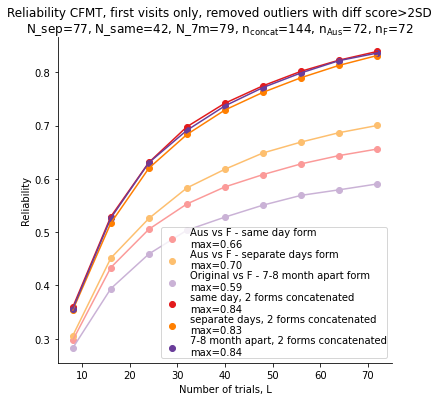

In [22]:
pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
labels = []

fig, ax = plt.subplots(1,1, figsize=(6,6))

for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Aus vs F - same day'),
    (array_corr_fxn_CFMT_AusF_nooutliers, n_trials_list_CFMT_AusF_nooutliers, 'Aus vs F - separate days'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers, n_trials_list_CFMT_origFmonth_nooutliers, 'Original vs F - 7-8 month apart'),
]):
    # plot Aus vs F
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{label} form\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i])
    
    labels += label.split(' - ')[1:]

# add the full concatenated 2 forms
for i, (arr, x_list) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers),
    (array_corr_fxn_CFMT_AusF_concat_nooutliers, n_trials_list_CFMT_AusF_concat_nooutliers),
    (array_corr_fxn_CFMT_origFmonth_concat_nooutliers, n_trials_list_CFMT_origFmonth_concat_nooutliers),
]):
    
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{labels[i]}, 2 forms concatenated\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i+1])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i+1])

ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

sns.despine()

plt.suptitle(f'Reliability CFMT, first visits only, removed outliers with diff score>{std_thr}SD\nN_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}', 
             y=.95)
plt.show()

#### Do subsampling of CFMT subjects without outliers
[top](#top)

To compensate for the fact that there is only 42 subjects who have it on the same day and 77 or 79 that have it on separate days. To be able to directly compare, downsample the same day CFMT to have the same number of subjects as the separate days.

In [23]:
# how many times to sample the number of subjects
N_iter_sampling = 50

# predefine arrays
array_corr_fxn_CFMT_AusF_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_AusF_nooutliers.shape)
array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_AusF_concat_nooutliers.shape)

print(f"""Without ourliers in difference score (>{std_thr} SD)
N same day: {N_CFMT_Aus2F2_nooutliers}\nN separate days: {N_CFMT_AusF_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_Aus_nooutliers.shape[0]==N_CFMT_AusF_nooutliers

for i in range(N_iter_sampling):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_AusF_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation 
    array_corr_fxn_CFMT_AusF_nooutliers_sampled[i], n_trials_list_CFMT_AusF_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

    # and all days concat
    array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled[i], n_trials_list_CFMT_concat_AusF_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_AusF_concat_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_AusF_concat_nooutliers[rnd_idx,:], total_n_trials_CFMT_AusF_concat_nooutliers, step=8)



Without ourliers in difference score (>2 SD)
N same day: 42
N separate days: 77

Taking random trials from the two different arrays.
Process took: 3.25 s which is 0.05 min.
Process took: 3.53 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.22 s which is 0.05 min.
Process took: 3.41 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.09 s which is 0.05 min.
Process took: 3.42 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.18 s which is 0.05 min.
Process took: 3.44 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.21 s which is 0.05 min.
Process took: 3.47 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.23 s which is 0.05 min.
Process took: 3.35 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.14 s which is 0.05 min.
Process took: 3.47 s which is 0.06 

In [24]:
# how many times to sample the number of subjects
N_iter_sampling = 50

# predefine arrays
array_corr_fxn_CFMT_origFmonth_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_origFmonth_nooutliers.shape)
array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_origFmonth_concat_nooutliers.shape)

print(f"""Without ourliers in difference score (>{std_thr} SD)
N same day: {N_CFMT_Aus2F2_nooutliers}\nN separate days: {N_CFMT_origFmonth_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_orig_nooutliers.shape[0]==N_CFMT_origFmonth_nooutliers

for i in range(N_iter_sampling):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_origFmonth_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation 
    array_corr_fxn_CFMT_origFmonth_nooutliers_sampled[i], n_trials_list_CFMT_origFmonth_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], 2*total_n_trials_CFMT_orig_nooutliers, step=8)

    # and all days concat
    array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled[i], n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_origFmonth_concat_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_origFmonth_concat_nooutliers[rnd_idx,:], total_n_trials_CFMT_origFmonth_concat_nooutliers, step=8)



Without ourliers in difference score (>2 SD)
N same day: 42
N separate days: 79

Taking random trials from the two different arrays.
Process took: 3.00 s which is 0.05 min.
Process took: 3.29 s which is 0.05 min.
Taking random trials from the two different arrays.
Process took: 3.22 s which is 0.05 min.
Process took: 3.49 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.37 s which is 0.06 min.
Process took: 3.45 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.22 s which is 0.05 min.
Process took: 3.36 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.08 s which is 0.05 min.
Process took: 3.48 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.23 s which is 0.05 min.
Process took: 3.50 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.27 s which is 0.05 min.
Process took: 3.55 s which is 0.06 

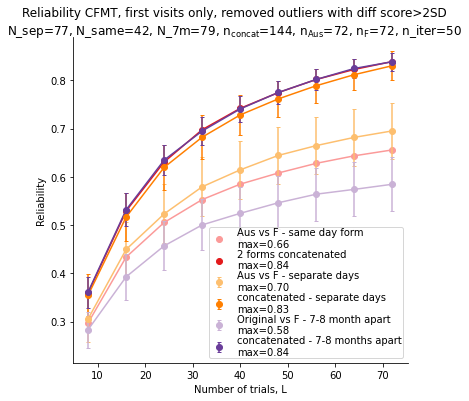

In [25]:
pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]


fig, ax = plt.subplots(1,1, figsize=(6,6))
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Aus vs F - same day'),
]):
    # plot Aus vs F
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{label} form\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i])

# add the full concatenated 2 forms
for i, (arr, x_list) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers),
]):
    
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'2 forms concatenated\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i+1])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i+1])


# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Aus vs F - separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'concatenated - separate days'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, 'Original vs F - 7-8 month apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, 'concatenated - 7-8 months apart'),
]):
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
    ax.errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[i+2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
    ax.plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT[i+2])
    
    
ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

sns.despine()

plt.suptitle(f"""Reliability CFMT, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}""", 
             y=.95)
plt.show()

### Are CFMT curves significantly different?
[top](#top)

To answer this question, we have to treat the three comparisons differently. We will look at the largest $L$* and check if the reliability sampling distributions are significantly different (t-test, permutation test) at this point. We can do this comparison directly for separate days and 7-8 months apart as they have basically the same number of subjects (77 and 79). The other two comparisons, however, we can't do directly (see the spread) so there are two methods:
1. randomly subsample separate/months apart to have N=42 and do 1 comparison,
1. 100x randomly subsample separate/months apart to have N=42 and count how many times it was significant.
1. 100x randomly subsample separate/months apart to have N=42, compute expected true reliability and compare their distribution.

Because the t-test is not the best method for this statistics, we will also look at Cohen's d and permutation tests for all three comparisons.

*We can't really do the comparison for largest $L$ as there we sample all trials, so the correlation is always the same and there is no variance. Therefore, I take roughly half of it, it is 36 in this case. I also need $L=36$ to calculate the expected value of test-retest reliability (true reliability) and it is the maximum I can take.

In [26]:
import scipy
import pingouin as pg

def permutation_test(data, rng_shuffle=np.random.default_rng(0)):
    # shuffle data
    rng_shuffle.shuffle(data)
    # split it
    arr1, arr2 = np.split(data, 2)
#     assert arr1.size == arr2.size
    
    return np.nanmean(arr1)-np.nanmean(arr2)

In [27]:
assert (n_trials_list_CFMT_AusF_nooutliers == n_trials_list_CFMT_origFmonth_nooutliers).all

# check the index, this we still do for 40 as we had it precomputed
assert 40 == n_trials_list_CFMT_AusF_nooutliers[4] == n_trials_list_CFMT_origFmonth_nooutliers[4]

print(f"""Separate days vs 7-8 months apart at L={n_trials_list_CFMT_AusF_nooutliers[4]}, N 7-8m={N_CFMT_origFmonth_nooutliers}, N separate days={N_CFMT_AusF_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_AusF_concat_nooutliers[4], 
                      array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4], nan_policy='omit')}""")

pg.ttest(array_corr_fxn_CFMT_AusF_concat_nooutliers[4], array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4], paired=False)

Separate days vs 7-8 months apart at L=40, N 7-8m=79, N separate days=77:
Ttest_indResult(statistic=-3.6044018504355644, pvalue=0.0003205342107169357)


/Users/jan/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/jan/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.604402,1998,two-sided,0.000321,"[-0.01, -0.0]",0.161194,31.123,0.949778


#### Method 1
Subsample only once

In [28]:
# predefine arrays

print(f"""Without ourliers in difference score (>{std_thr} SD), downsampling to {N_CFMT_Aus2F2_nooutliers}
N same day: {N_CFMT_Aus2F2_nooutliers}
N separate days: {N_CFMT_AusF_nooutliers}
N 7-8m: {N_CFMT_origFmonth_nooutliers}
""")

###
# check that dimensions are ok
assert all_trials_reshaped_CFMT_Aus_nooutliers.shape[0]==N_CFMT_AusF_nooutliers

# define seed
rng_N_sample = np.random.default_rng(0)

# randomly sample people
rnd_idx = rng_N_sample.choice(range(N_CFMT_AusF_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)

# do the calculation 
array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random, n_trials_list_CFMT_AusF_nooutliers_sampled_ttest_random = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

assert (n_trials_list_CFMT_AusF_nooutliers_sampled_ttest_random==n_trials_list_CFMT_Aus2F2_nooutliers).all

# check the index
assert 40 == n_trials_list_CFMT_Aus2F2_nooutliers[4] == n_trials_list_CFMT_AusF_nooutliers_sampled_ttest_random[4]

print(f"""
Separate days vs same days at L={n_trials_list_CFMT_AusF_nooutliers_sampled_ttest_random[4]}, N={N_CFMT_Aus2F2_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_Aus2F2_nooutliers[4], 
                      array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random[4], nan_policy='omit')}
                      """)

###

# check that dimensions are ok
assert all_trials_reshaped_CFMT_orig_nooutliers.shape[0]==N_CFMT_origFmonth_nooutliers

# define seed
rng_N_sample = np.random.default_rng(0)

# randomly sample people
rnd_idx = rng_N_sample.choice(range(N_CFMT_origFmonth_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)

# do the calculation 
array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random, n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest_random = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], 2*total_n_trials_CFMT_orig_nooutliers, step=8)

assert (n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest_random==n_trials_list_CFMT_Aus2F2_nooutliers).all
# check the index
assert 40 == n_trials_list_CFMT_Aus2F2_nooutliers[4] == n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest_random[4]

print(f"""
7-8m apart vs same days at L={n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest_random[4]}, N={N_CFMT_Aus2F2_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_Aus2F2_nooutliers[4], 
                      array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random[4], nan_policy='omit')}
                      """)


Without ourliers in difference score (>2 SD), downsampling to 42
N same day: 42
N separate days: 77
N 7-8m: 79

Taking random trials from the two different arrays.
Process took: 3.77 s which is 0.06 min.

Separate days vs same days at L=40, N=42:
Ttest_indResult(statistic=22.255460355916874, pvalue=3.2948352357632455e-98)
                      
Taking random trials from the two different arrays.
Process took: 3.83 s which is 0.06 min.

7-8m apart vs same days at L=40, N=42:
Ttest_indResult(statistic=-9.778198937616077, pvalue=4.332062441155648e-22)
                      


same vs 7-8m (red vs blue): 
Ttest_indResult(statistic=-8.726902642488932, pvalue=5.411883005065286e-18)
same vs separate (red vs yellow):
 Ttest_indResult(statistic=10.57136207318927, pvalue=1.8755880316438577e-25)
separate vs 7-8m (yellow vs blue):
 Ttest_indResult(statistic=19.074276298041134, pvalue=1.1924669423319027e-74)
same vs 7-8m (red vs blue):
               T   dof alternative         p-val           CI95%   cohen-d  \
T-test -8.726903  1998   two-sided  5.411883e-18  [-0.06, -0.04]  0.390279   

             BF10  power  
T-test  6.696e+14    1.0  
same vs separate (red vs yellow):
                T   dof alternative         p-val         CI95%   cohen-d  \
T-test  10.571362  1998   two-sided  1.875588e-25  [0.05, 0.08]  0.472766   

            BF10  power  
T-test  1.47e+22    1.0  
separate vs 7-8m (yellow vs blue):
                T   dof alternative         p-val         CI95%   cohen-d  \
T-test  19.074276  1998   two-sided  1.192467e-74  [0.11, 0.13]  0.853028   

 

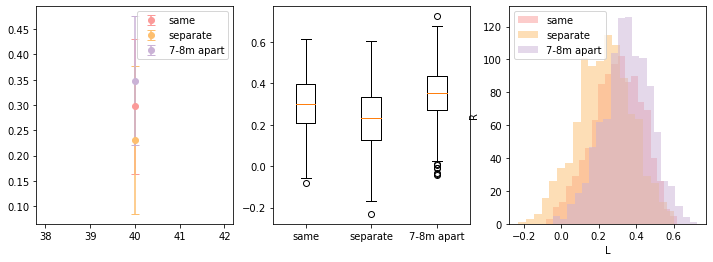

In [29]:
# extract values to better work with it
a = array_corr_fxn_CFMT_Aus2F2_nooutliers[0]
b = array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random[0]
c = array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random[0]


fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].errorbar([40], a.mean(), yerr=a.std(), 
                capsize=4, label='same', color=pallette_CFMT[0], marker='o', linestyle='None')

axs[0].errorbar([40], c.mean(), yerr=c.std(), 
                capsize=4, label='separate', color=pallette_CFMT[2], marker='o', linestyle='None')

axs[0].errorbar([40], b.mean(), yerr=b.std(), 
             capsize=4, label='7-8m apart', color=pallette_CFMT[4], marker='o', linestyle='None')


plt.xlabel('L')
plt.ylabel('R')
axs[0].legend()
axs[1].boxplot([a, c, b], labels=['same', 'separate', '7-8m apart'])
axs[2].hist(a, bins=20, alpha=0.5, label='same', color=pallette_CFMT[0])
axs[2].hist(c, bins=20, alpha=0.5, label='separate', color=pallette_CFMT[2])
axs[2].hist(b, bins=20, alpha=0.5, label='7-8m apart', color=pallette_CFMT[4])
axs[2].legend()

print(f"same vs 7-8m (red vs blue): \n{scipy.stats.ttest_ind(a, b, nan_policy='omit')}")
print(f"same vs separate (red vs yellow):\n {scipy.stats.ttest_ind(a, c, nan_policy='omit')}")
print(f"separate vs 7-8m (yellow vs blue):\n {scipy.stats.ttest_ind(b, c, nan_policy='omit')}")

# t-tests in pingouin
print(f"same vs 7-8m (red vs blue):\n{pg.ttest(a, b, paired=False)}")
print(f"same vs separate (red vs yellow):\n{pg.ttest(a, c, paired=False)}")
print(f"separate vs 7-8m (yellow vs blue):\n{pg.ttest(b, c, paired=False)}")


# Cohen's d for same vs 7-8m (red vs blue)
d_same_vs_7_8m = pg.compute_effsize(a, b, paired=False, eftype='cohen')

# Cohen's d for same vs separate (red vs yellow)
d_same_vs_separate = pg.compute_effsize(a, c, paired=False, eftype='cohen')

# Cohen's d for separate vs 7-8m (yellow vs blue)
d_separate_vs_7_8m = pg.compute_effsize(b, c, paired=False, eftype='cohen')

print(f"Cohen's d for same vs 7-8m: {d_same_vs_7_8m}")
print(f"Cohen's d for same vs separate: {d_same_vs_separate}")
print(f"Cohen's d for separate vs 7-8m: {d_separate_vs_7_8m}")

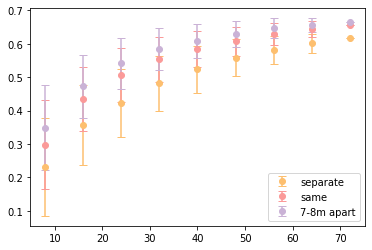

In [30]:
# plot scatter with error bars
plt.errorbar(n_trials_list_CFMT_AusF_nooutliers_sampled_ttest_random, 
             array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random.mean(axis=1), 
             yerr=np.std(array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random, axis=1),
             label='separate', capsize=4, color=pallette_CFMT[2], marker='o', linestyle='None')

plt.errorbar(n_trials_list_CFMT_Aus2F2_nooutliers, 
             array_corr_fxn_CFMT_Aus2F2_nooutliers.mean(axis=1), 
             yerr=np.std(array_corr_fxn_CFMT_Aus2F2_nooutliers, axis=1),
             label='same', capsize=4, color=pallette_CFMT[0], marker='o', linestyle='None')

plt.errorbar(n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest_random, 
             array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random.mean(axis=1), 
             yerr=np.std(array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random, axis=1),
             label='7-8m apart', capsize=4, color=pallette_CFMT[4], marker='o', linestyle='None')

plt.legend()
plt.show()

#### Method 1 with permutation tests
[top](#top)

In [31]:
n_permutations = 10000

permutation_same_separate = np.zeros(n_permutations)
permutation_same_month = np.zeros(n_permutations)
permutation_month_separate = np.zeros(n_permutations)

for i in range(n_permutations):
    permutation_same_separate[i] = permutation_test(np.concatenate([a,c]), np.random.default_rng(i))
    permutation_same_month[i] = permutation_test(np.concatenate([a,b]), np.random.default_rng(i))
    permutation_month_separate[i] = permutation_test(np.concatenate([b,c]), np.random.default_rng(i))
    
    

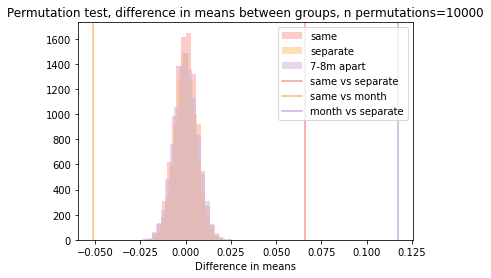

In [32]:
plt.hist(permutation_same_separate, bins=20, alpha=0.5, label='same', color=pallette_CFMT[0])
plt.hist(permutation_same_month, bins=20, alpha=0.5, label='separate', color=pallette_CFMT[2])
plt.hist(permutation_month_separate, bins=20, alpha=0.5, label='7-8m apart', color=pallette_CFMT[4])

plt.axvline(np.nanmean(a)-np.nanmean(c), label='same vs separate', color=pallette_CFMT[0])
plt.axvline(np.nanmean(a)-np.nanmean(b), label='same vs month', color=pallette_CFMT[2])
plt.axvline(np.nanmean(b)-np.nanmean(c), label='month vs separate', color=pallette_CFMT[4])

plt.xlabel('Difference in means')
plt.title(f'Permutation test, difference in means between groups, n permutations={n_permutations}')
plt.legend()
plt.show()

#### Method 2
Subsample multiple times, count significance. This is failing as the p values don't make any sense and are not representative of what's going on.

In [33]:
# define how many times to sample
N_iter_sampling_ttest = 10#50#0

# predefine arrays
array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,)+ array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest_random.shape)

p_values_array_sep_vs_same = np.zeros(N_iter_sampling_ttest)
t_values_array_sep_vs_same = np.zeros(N_iter_sampling_ttest)

print(f"""Without ourliers in difference score (>{std_thr} SD), downsampling to {N_CFMT_Aus2F2_nooutliers}
N same day: {N_CFMT_Aus2F2_nooutliers}
N separate days: {N_CFMT_AusF_nooutliers}
N 7-8m: {N_CFMT_origFmonth_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_Aus_nooutliers.shape[0]==N_CFMT_AusF_nooutliers

for i in range(N_iter_sampling_ttest):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_AusF_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation 
    array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest[i], n_trials_list_CFMT_AusF_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

    # check the index
    assert 40 == n_trials_list_CFMT_Aus2F2_nooutliers[4] == n_trials_list_CFMT_AusF_nooutliers_sampled_ttest[4]

    # perform the test
    t_values_array_sep_vs_same[i], p_values_array_sep_vs_same[i] = scipy.stats.ttest_ind(
        array_corr_fxn_CFMT_Aus2F2_nooutliers[4], 
        array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest[i][4], nan_policy='omit')
    
    
print(p_values_array_sep_vs_same)

Without ourliers in difference score (>2 SD), downsampling to 42
N same day: 42
N separate days: 77
N 7-8m: 79

Taking random trials from the two different arrays.
Process took: 4.30 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.21 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.19 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.22 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.19 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.18 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 4.01 s which is 0.07 min.
Taking random trials from the two different arrays.
Process took: 3.82 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.77 s which is 0.06 min.
Taking random trials from the two different arrays.
Process 

In [34]:
# define how many times to sample
N_iter_sampling_ttest = 10

# predefine arrays
array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,)+ array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest_random.shape)

p_values_array_month_vs_same = np.zeros(N_iter_sampling_ttest)
t_values_array_month_vs_same = np.zeros(N_iter_sampling_ttest)

print(f"""Without ourliers in difference score (>{std_thr} SD), downsampling to {N_CFMT_Aus2F2_nooutliers}
N same day: {N_CFMT_Aus2F2_nooutliers}
N separate days: {N_CFMT_AusF_nooutliers}
N 7-8m: {N_CFMT_origFmonth_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_orig_nooutliers.shape[0]==N_CFMT_origFmonth_nooutliers

for i in range(N_iter_sampling_ttest):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_origFmonth_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)

    # do the calculation 
    array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest[i], n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], 2*total_n_trials_CFMT_orig_nooutliers, step=8)

    # check the index
    assert 40 == n_trials_list_CFMT_Aus2F2_nooutliers[4] == n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest[4]

    # perform the test
    t_values_array_month_vs_same[i], p_values_array_month_vs_same[i] = scipy.stats.ttest_ind(
        array_corr_fxn_CFMT_Aus2F2_nooutliers[4], 
        array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest[i][4], nan_policy='omit')
    
    
print(p_values_array_month_vs_same)

Without ourliers in difference score (>2 SD), downsampling to 42
N same day: 42
N separate days: 77
N 7-8m: 79

Taking random trials from the two different arrays.
Process took: 3.68 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.55 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.51 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.43 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.49 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.45 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.52 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.62 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 3.72 s which is 0.06 min.
Taking random trials from the two different arrays.
Process 

#### Method 2 with permutation testing
Subsample multiple times, do permutation testing

In [35]:
# define how many times to sample
N_iter_sampling_ttest = 100
n_permutations = 1000

# calculate first the same day
array_corr_fxn_CFMT_Aus2F2_nooutliers_step36, n_trials_list_CFMT_Aus2F2_nooutliers_step36 = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2_nooutliers, all_trials_reshaped_CFMT_F2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers+total_n_trials_CFMT_F2_nooutliers, step=36)
a = array_corr_fxn_CFMT_Aus2F2_nooutliers_step36[0]
# and compute the individual days
array_corr_fxn_CFMT_Aus2F2_Aus2_nooutliers_step36, n_trials_list_CFMT_Aus2F2_Aus2_nooutliers_step36 = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2_nooutliers, all_trials_reshaped_CFMT_Aus2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers, step=36)
array_corr_fxn_CFMT_Aus2F2_F2_nooutliers_step36, n_trials_list_CFMT_Aus2F2_F2_nooutliers_step36 = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_F2_nooutliers, all_trials_reshaped_CFMT_F2_nooutliers, total_n_trials_CFMT_F2_nooutliers, step=36)



# predefine arrays
array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,2,1000))
array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,2,1000))
# and also short arrays
array_corr_fxn_CFMT_origFmonth_orig_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,1,1000))
array_corr_fxn_CFMT_origFmonth_F_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,1,1000))
array_corr_fxn_CFMT_AusF_Aus_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,1,1000))
array_corr_fxn_CFMT_AusF_F_nooutliers_sampled_ttest = np.zeros((N_iter_sampling_ttest,1,1000))

# predefine arrays for permutations
permutation_same_separate = np.zeros((N_iter_sampling_ttest, n_permutations))
permutation_same_month = np.zeros((N_iter_sampling_ttest, n_permutations))
permutation_separate_month = np.zeros((N_iter_sampling_ttest, n_permutations))

arr_difference_same_separate = np.zeros(N_iter_sampling_ttest)
arr_difference_same_month = np.zeros(N_iter_sampling_ttest)
arr_difference_separate_month = np.zeros(N_iter_sampling_ttest)


print(f"""Without ourliers in difference score (>{std_thr} SD), downsampling to {N_CFMT_Aus2F2_nooutliers}
N same day: {N_CFMT_Aus2F2_nooutliers}
N separate days: {N_CFMT_AusF_nooutliers}
N 7-8m: {N_CFMT_origFmonth_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_orig_nooutliers.shape[0]==N_CFMT_origFmonth_nooutliers

for i in range(N_iter_sampling_ttest):
    ### month
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_origFmonth_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)

    # do the calculation (orig vs F)
    array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest[i], n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], 2*total_n_trials_CFMT_orig_nooutliers, step=36)
    # and do also the individual groups
    array_corr_fxn_CFMT_origFmonth_orig_nooutliers_sampled_ttest[i], n_trials_list_CFMT_origFmonth_orig_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], total_n_trials_CFMT_orig_nooutliers, step=36)
    array_corr_fxn_CFMT_origFmonth_F_nooutliers_sampled_ttest[i], n_trials_list_CFMT_origFmonth_F_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], total_n_trials_CFMT_Fmonth_nooutliers, step=36)

    # check the index
    assert 36 == n_trials_list_CFMT_Aus2F2_nooutliers_step36[0] == n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest[0]

    #### separate days
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_AusF_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation (Aus vs F)
    array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest[i], n_trials_list_CFMT_AusF_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=36)
    # and do also the individual groups
    array_corr_fxn_CFMT_AusF_Aus_nooutliers_sampled_ttest[i], n_trials_list_CFMT_AusF_Aus_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers, step=36)
    array_corr_fxn_CFMT_AusF_F_nooutliers_sampled_ttest[i], n_trials_list_CFMT_AusF_F_nooutliers_sampled_ttest = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_F_nooutliers, step=36)
    
    
    # check the index
    assert 36 == n_trials_list_CFMT_Aus2F2_nooutliers_step36[0] == n_trials_list_CFMT_AusF_nooutliers_sampled_ttest[0]

    
    # perform the test
#     a = array_corr_fxn_CFMT_Aus2F2_nooutliers_step36[0]
    b = array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest[i,0]
    c = array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest[i,0]

    for j in range(n_permutations):
        permutation_same_separate[i,j] = permutation_test(np.concatenate([a,c]), np.random.default_rng(j))
        permutation_same_month[i,j] = permutation_test(np.concatenate([a,b]), np.random.default_rng(j))
        permutation_separate_month[i,j] = permutation_test(np.concatenate([b,c]), np.random.default_rng(j))
        
    arr_difference_same_month[i] = np.nanmean(a)-np.nanmean(b)
    arr_difference_same_separate[i] = np.nanmean(a)-np.nanmean(c)
    arr_difference_separate_month = np.nanmean(c)-np.nanmean(b)


Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Without ourliers in difference score (>2 SD), downsampling to 42
N same day: 42
N separate days: 77
N 7-8m: 79

Taking random trials from the two different arrays.
Process took: 0.86 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.86 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.88 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.89 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Taking random trials from th

Taking random trials from the two different arrays.
Process took: 0.83 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.81 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.82 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.86 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.87 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process 

Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.84 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.87 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.84 s which is 0.01 min.
Process 

Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.85 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 0.88 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Taking random trials from the two different arrays.
Process 

Process took: 1.02 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.72 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 1.92 s which is 0.03 min.
Process took: 0.66 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 1.46 s which is 0.02 min.
Process took: 0.68 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Taking random trials from the two different arrays.
Process took: 2.21 s which is 0.04 min.
Process took: 1.33 s which is 0.02 min.
Process took: 1.54 s which is 0.03 min.
Taking random trials from the two different arrays.
Process took: 1.95 s which is 0.03 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.40 s which is 0.02 min.
Taking random trials from the two different arrays.
Process took: 1.11 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Taking random trials

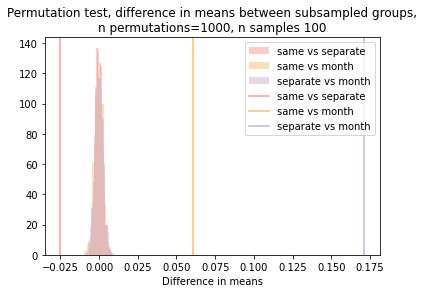

mean:-0.000, SD:0.0024, value:-0.025, percentile: 0.0
mean:-0.000, SD:0.0028, value:0.061, percentile: 100.0
mean:-0.000, SD:0.0027, value:0.171, percentile: 100.0


In [36]:

plt.hist(permutation_same_separate.mean(axis=0), bins=20, alpha=0.5, label='same vs separate', color=pallette_CFMT[0])
plt.hist(permutation_same_month.mean(axis=0), bins=20, alpha=0.5, label='same vs month', color=pallette_CFMT[2])
plt.hist(permutation_separate_month.mean(axis=0), bins=20, alpha=0.5, label='separate vs month', color=pallette_CFMT[4])

plt.axvline(arr_difference_same_separate.mean(), label='same vs separate', color=pallette_CFMT[0])
plt.axvline(arr_difference_same_month.mean(), label='same vs month', color=pallette_CFMT[2])
plt.axvline(arr_difference_separate_month.mean(), label='separate vs month', color=pallette_CFMT[4])

plt.xlabel('Difference in means')
plt.title(f'Permutation test, difference in means between subsampled groups,\nn permutations={n_permutations}, n samples {N_iter_sampling_ttest}')
plt.legend()
plt.show()


for arr, val in zip([permutation_same_separate, permutation_same_month, permutation_separate_month],
                    [arr_difference_same_separate, arr_difference_same_month, arr_difference_separate_month]):
    print(f'mean:{arr.mean():.3f}, SD:{arr.mean(axis=0).std():.4f}, value:{val.mean():.3f}, percentile: {scipy.stats.percentileofscore(arr.mean(axis=0), val.mean())}')

#### Method 3
Use the reliability distributions, average across the samples of participants (in months and separate days) and compute from them distribution of true (test-retest) reliability. Compare then the three distributions to each other. This is what is reported in the article and this is comparing the three test-retest curves (not the pooled/concatenated).

[top](#top)

In [37]:
# check that we do it for the same L
assert n_trials_list_CFMT_Aus2F2_nooutliers_step36[0] == n_trials_list_CFMT_AusF_nooutliers_sampled_ttest[0] == n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest[0]

# then also with the short arrays
assert n_trials_list_CFMT_Aus2F2_nooutliers_step36[0] == n_trials_list_CFMT_Aus2F2_Aus2_nooutliers_step36[0] == n_trials_list_CFMT_Aus2F2_F2_nooutliers_step36[0]
assert n_trials_list_CFMT_AusF_nooutliers_sampled_ttest[0] == n_trials_list_CFMT_AusF_Aus_nooutliers_sampled_ttest[0] == n_trials_list_CFMT_AusF_F_nooutliers_sampled_ttest[0]
assert n_trials_list_CFMT_origFmonth_nooutliers_sampled_ttest[0] == n_trials_list_CFMT_origFmonth_orig_nooutliers_sampled_ttest[0] == n_trials_list_CFMT_origFmonth_F_nooutliers_sampled_ttest[0]

# compute the true reliability
arr_true_rel_same = get_true_correlation(array_corr_fxn_CFMT_Aus2F2_nooutliers_step36[0],
                         array_corr_fxn_CFMT_Aus2F2_Aus2_nooutliers_step36[0], 
                         array_corr_fxn_CFMT_Aus2F2_F2_nooutliers_step36[0])

arr_true_rel_separate = get_true_correlation(array_corr_fxn_CFMT_AusF_nooutliers_sampled_ttest.mean(axis=0)[0],
                         array_corr_fxn_CFMT_AusF_Aus_nooutliers_sampled_ttest.mean(axis=0)[0], 
                         array_corr_fxn_CFMT_AusF_F_nooutliers_sampled_ttest.mean(axis=0)[0])

arr_true_rel_month = get_true_correlation(array_corr_fxn_CFMT_origFmonth_nooutliers_sampled_ttest.mean(axis=0)[0],
                         array_corr_fxn_CFMT_origFmonth_orig_nooutliers_sampled_ttest.mean(axis=0)[0], 
                         array_corr_fxn_CFMT_origFmonth_F_nooutliers_sampled_ttest.mean(axis=0)[0])

# define data
df_true_reliability_sampled = pd.DataFrame({
    'true_reliability': np.concatenate([arr_true_rel_same, arr_true_rel_separate, arr_true_rel_month]),
    'label': arr_true_rel_same.shape[0]*['same_day'] + arr_true_rel_separate.shape[0]*['separate_days'] + arr_true_rel_month.shape[0]*['month_apart'],
})


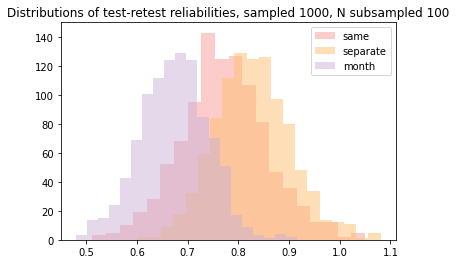

In [38]:
plt.hist(arr_true_rel_same, bins=20, alpha=0.5, label='same', color=pallette_CFMT[0])
plt.hist(arr_true_rel_separate, bins=20, alpha=0.5, label='separate', color=pallette_CFMT[2])
plt.hist(arr_true_rel_month, bins=20, alpha=0.5, label='month', color=pallette_CFMT[4])

plt.legend()
plt.title(f'Distributions of test-retest reliabilities, sampled {arr_true_rel_same.shape[0]}, N subsampled {N_iter_sampling_ttest}')
plt.show()

In [39]:
# do one-way ANOVA test
pg.anova(data=df_true_reliability_sampled, dv='true_reliability', between='label', detailed=True)


,Source,SS,DF,MS,F,p-unc,np2
0,label,12.322745,2,6.161372,1071.891239,0.0,0.417015
1,Within,17.227152,2997,0.005748,NaN,NaN,NaN


F(between groups df, within groups df), https://www.statology.org/how-to-report-anova-results/

F(2, 2997) = 1071.89; p < 0.001; MSE = 6.16; ηp2 = 0.42

In [40]:
# Perform Tukey's HSD test for multiple comparisons
posthoc = pg.pairwise_tukey(data=df_true_reliability_sampled, dv='true_reliability', between='label', effsize='Cohen')

posthoc

,A,B,mean(A),mean(B),diff,se,T,p-tukey,Cohen
0,month_apart,same_day,0.673976,0.772348,-0.098372,0.003391,-29.013135,0.0,-1.297507
1,month_apart,separate_days,0.673976,0.829116,-0.155140,0.003391,-45.755813,0.0,-2.046262
2,same_day,separate_days,0.772348,0.829116,-0.056768,0.003391,-16.742678,0.0,-0.748755


In [41]:
# compute CI for the test
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_true_reliability_sampled['true_reliability'], df_true_reliability_sampled['label'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
month_apart,same_day,0.0984,-0.0,0.0904,0.1063,True
month_apart,separate_days,0.1551,-0.0,0.1472,0.1631,True
same_day,separate_days,0.0568,-0.0,0.0488,0.0647,True


### Statistical testing of pooled curves vs test-retest
[top](#top)

Compare reliability distributions for a given $L$ (here $L=40$, see above) of the pooled data and the test-retest.

In [42]:
# use the pingouin function but modify it to remove the Bayes factors that would not work
# https://github.com/raphaelvallat/pingouin/blob/main/src/pingouin/parametric.py#L21C1-L332C41

def ttest(x, y, paired=False, alternative="two-sided", correction="auto", r=0.707, confidence=0.95):
    """T-test.

    Parameters
    ----------
    x : array_like
        First set of observations.
    y : array_like or float
        Second set of observations. If ``y`` is a single value, a one-sample
        T-test is computed against that value (= "mu" in the t.test R
        function).
    paired : boolean
        Specify whether the two observations are related (i.e. repeated
        measures) or independent.
    alternative : string
        Defines the alternative hypothesis, or tail of the test. Must be one of
        "two-sided" (default), "greater" or "less". Both "greater" and "less" return one-sided
        p-values. "greater" tests against the alternative hypothesis that the mean of ``x``
        is greater than the mean of ``y``.
    correction : string or boolean
        For unpaired two sample T-tests, specify whether or not to correct for
        unequal variances using Welch separate variances T-test. If 'auto', it
        will automatically uses Welch T-test when the sample sizes are unequal,
        as recommended by Zimmerman 2004.
    r : float
        Cauchy scale factor for computing the Bayes Factor.
        Smaller values of r (e.g. 0.5), may be appropriate when small effect
        sizes are expected a priori; larger values of r are appropriate when
        large effect sizes are expected (Rouder et al 2009).
        The default is 0.707 (= :math:`\\sqrt{2} / 2`).
    confidence : float
        Confidence level for the confidence intervals (0.95 = 95%)

        .. versionadded:: 0.3.9

    Returns
    -------
    stats : :py:class:`pandas.DataFrame`

        * ``'T'``: T-value
        * ``'dof'``: degrees of freedom
        * ``'alternative'``: alternative of the test
        * ``'p-val'``: p-value
        * ``'CI95%'``: confidence intervals of the difference in means
        * ``'cohen-d'``: Cohen d effect size
        * ``'BF10'``: Bayes Factor of the alternative hypothesis
        * ``'power'``: achieved power of the test ( = 1 - type II error)

    See also
    --------
    mwu, wilcoxon, anova, rm_anova, pairwise_tests, compute_effsize

    Notes
    -----
    Missing values are automatically removed from the data. If ``x`` and
    ``y`` are paired, the entire row is removed (= listwise deletion).

    The **T-value for unpaired samples** is defined as:

    .. math::

        t = \\frac{\\overline{x} - \\overline{y}}
        {\\sqrt{\\frac{s^{2}_{x}}{n_{x}} + \\frac{s^{2}_{y}}{n_{y}}}}

    where :math:`\\overline{x}` and :math:`\\overline{y}` are the sample means,
    :math:`n_{x}` and :math:`n_{y}` are the sample sizes, and
    :math:`s^{2}_{x}` and :math:`s^{2}_{y}` are the sample variances.
    The degrees of freedom :math:`v` are :math:`n_x + n_y - 2` when the sample
    sizes are equal. When the sample sizes are unequal or when
    :code:`correction=True`, the Welch–Satterthwaite equation is used to
    approximate the adjusted degrees of freedom:

    .. math::

        v = \\frac{(\\frac{s^{2}_{x}}{n_{x}} + \\frac{s^{2}_{y}}{n_{y}})^{2}}
        {\\frac{(\\frac{s^{2}_{x}}{n_{x}})^{2}}{(n_{x}-1)} +
        \\frac{(\\frac{s^{2}_{y}}{n_{y}})^{2}}{(n_{y}-1)}}

    The p-value is then calculated using a T distribution with :math:`v`
    degrees of freedom.

    The T-value for **paired samples** is defined by:

    .. math:: t = \\frac{\\overline{x}_d}{s_{\\overline{x}}}

    where

    .. math:: s_{\\overline{x}} = \\frac{s_d}{\\sqrt n}

    where :math:`\\overline{x}_d` is the sample mean of the differences
    between the two paired samples, :math:`n` is the number of observations
    (sample size), :math:`s_d` is the sample standard deviation of the
    differences and :math:`s_{\\overline{x}}` is the estimated standard error
    of the mean of the differences. The p-value is then calculated using a
    T-distribution with :math:`n-1` degrees of freedom.

    The scaled Jeffrey-Zellner-Siow (JZS) Bayes Factor is approximated
    using the :py:func:`pingouin.bayesfactor_ttest` function.

    Results have been tested against JASP and the `t.test` R function.

    References
    ----------
    * https://www.itl.nist.gov/div898/handbook/eda/section3/eda353.htm

    * Delacre, M., Lakens, D., & Leys, C. (2017). Why psychologists should
      by default use Welch’s t-test instead of Student’s t-test.
      International Review of Social Psychology, 30(1).

    * Zimmerman, D. W. (2004). A note on preliminary tests of equality of
      variances. British Journal of Mathematical and Statistical
      Psychology, 57(1), 173-181.

    * Rouder, J.N., Speckman, P.L., Sun, D., Morey, R.D., Iverson, G.,
      2009. Bayesian t tests for accepting and rejecting the null
      hypothesis. Psychon. Bull. Rev. 16, 225–237.
      https://doi.org/10.3758/PBR.16.2.225

    Examples
    --------
    1. One-sample T-test.

    >>> from pingouin import ttest
    >>> x = [5.5, 2.4, 6.8, 9.6, 4.2]
    >>> ttest(x, 4).round(2)
              T  dof alternative  p-val         CI95%  cohen-d   BF10  power
    T-test  1.4    4   two-sided   0.23  [2.32, 9.08]     0.62  0.766   0.19

    2. One sided paired T-test.

    >>> pre = [5.5, 2.4, 6.8, 9.6, 4.2]
    >>> post = [6.4, 3.4, 6.4, 11., 4.8]
    >>> ttest(pre, post, paired=True, alternative='less').round(2)
               T  dof alternative  p-val          CI95%  cohen-d   BF10  power
    T-test -2.31    4        less   0.04  [-inf, -0.05]     0.25  3.122   0.12

    Now testing the opposite alternative hypothesis

    >>> ttest(pre, post, paired=True, alternative='greater').round(2)
               T  dof alternative  p-val         CI95%  cohen-d  BF10  power
    T-test -2.31    4     greater   0.96  [-1.35, inf]     0.25  0.32   0.02

    3. Paired T-test with missing values.

    >>> import numpy as np
    >>> pre = [5.5, 2.4, np.nan, 9.6, 4.2]
    >>> post = [6.4, 3.4, 6.4, 11., 4.8]
    >>> ttest(pre, post, paired=True).round(3)
                T  dof alternative  p-val          CI95%  cohen-d   BF10  power
    T-test -5.902    3   two-sided   0.01  [-1.5, -0.45]    0.306  7.169  0.073

    Compare with SciPy

    >>> from scipy.stats import ttest_rel
    >>> np.round(ttest_rel(pre, post, nan_policy="omit"), 3)
    array([-5.902,  0.01 ])

    4. Independent two-sample T-test with equal sample size.

    >>> np.random.seed(123)
    >>> x = np.random.normal(loc=7, size=20)
    >>> y = np.random.normal(loc=4, size=20)
    >>> ttest(x, y)
                   T  dof alternative         p-val         CI95%   cohen-d       BF10  power
    T-test  9.106452   38   two-sided  4.306971e-11  [2.64, 4.15]  2.879713  1.366e+08    1.0

    5. Independent two-sample T-test with unequal sample size. A Welch's T-test is used.

    >>> np.random.seed(123)
    >>> y = np.random.normal(loc=6.5, size=15)
    >>> ttest(x, y)
                   T        dof alternative     p-val          CI95%   cohen-d   BF10     power
    T-test  1.996537  31.567592   two-sided  0.054561  [-0.02, 1.65]  0.673518  1.469  0.481867

    6. However, the Welch's correction can be disabled:

    >>> ttest(x, y, correction=False)
                   T  dof alternative     p-val          CI95%   cohen-d   BF10     power
    T-test  1.971859   33   two-sided  0.057056  [-0.03, 1.66]  0.673518  1.418  0.481867

    Compare with SciPy

    >>> from scipy.stats import ttest_ind
    >>> np.round(ttest_ind(x, y, equal_var=True), 6)  # T value and p-value
    array([1.971859, 0.057056])
    """
    from scipy.stats import t, ttest_rel, ttest_ind, ttest_1samp

    try:  # pragma: no cover
        from scipy.stats._stats_py import _unequal_var_ttest_denom, _equal_var_ttest_denom
    except ImportError:  # pragma: no cover
        # Fallback for scipy<1.8.0
        from scipy.stats.stats import _unequal_var_ttest_denom, _equal_var_ttest_denom
    from pingouin import power_ttest, power_ttest2n, compute_effsize

    # Check arguments
    assert alternative in [
        "two-sided",
        "greater",
        "less",
    ], "Alternative must be one of 'two-sided' (default), 'greater' or 'less'."
    assert 0 < confidence < 1, "confidence must be between 0 and 1."

    x = np.asarray(x)
    y = np.asarray(y)

    if x.size != y.size and paired:
        warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")
        paired = False

    # Remove rows with missing values
    x, y = pg.remove_na(x, y, paired=paired)
    nx, ny = x.size, y.size

    if ny == 1:
        # Case one sample T-test
        tval, pval = ttest_1samp(x, y, alternative=alternative)

        # Some versions of scipy return an array for the t-value
        if isinstance(tval, Iterable):
            tval = tval[0]
        dof = nx - 1
        se = np.sqrt(x.var(ddof=1) / nx)
    if ny > 1 and paired is True:
        # Case paired two samples T-test
        # Do not compute if two arrays are identical (avoid SciPy warning)
        if np.array_equal(x, y):
            warnings.warn("x and y are equals. Cannot compute T or p-value.")
            tval, pval = np.nan, np.nan
        else:
            tval, pval = ttest_rel(x, y, alternative=alternative)
        dof = nx - 1
        se = np.sqrt(np.var(x - y, ddof=1) / nx)
        bf = bayesfactor_ttest(tval, nx, ny, paired=True, r=r)
    elif ny > 1 and paired is False:
        dof = nx + ny - 2
        vx, vy = x.var(ddof=1), y.var(ddof=1)
        # Case unpaired two samples T-test
        if correction is True or (correction == "auto" and nx != ny):
            # Use the Welch separate variance T-test
            tval, pval = ttest_ind(x, y, equal_var=False, alternative=alternative)
            # Compute sample standard deviation
            # dof are approximated using Welch–Satterthwaite equation
            dof, se = _unequal_var_ttest_denom(vx, nx, vy, ny)
        else:
            tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
            _, se = _equal_var_ttest_denom(vx, nx, vy, ny)

    # Effect size
    d = compute_effsize(x, y, paired=paired, eftype="cohen")

    # Confidence interval for the (difference in) means
    # Compare to the t.test r function
    if alternative == "two-sided":
        alpha = 1 - confidence
        conf = 1 - alpha / 2  # 0.975
    else:
        conf = confidence
    tcrit = t.ppf(conf, dof)
    ci = np.array([tval - tcrit, tval + tcrit]) * se
    if ny == 1:
        ci += y

    if alternative == "greater":
        ci[1] = np.inf
    elif alternative == "less":
        ci[0] = -np.inf

    # Rename CI
    ci_name = "CI%.0f%%" % (100 * confidence)

    # Achieved power
    if ny == 1:
        # One-sample
        power = power_ttest(
            d=d, n=nx, power=None, alpha=0.05, contrast="one-sample", alternative=alternative
        )
    if ny > 1 and paired is True:
        # Paired two-sample
        power = power_ttest(
            d=d, n=nx, power=None, alpha=0.05, contrast="paired", alternative=alternative
        )
    elif ny > 1 and paired is False:
        # Independent two-samples
        if nx == ny:
            # Equal sample sizes
            power = power_ttest(
                d=d, n=nx, power=None, alpha=0.05, contrast="two-samples", alternative=alternative
            )
        else:
            # Unequal sample sizes
            power = power_ttest2n(nx, ny, d=d, power=None, alpha=0.05, alternative=alternative)

    # Bayes factor
#     bf = bayesfactor_ttest(tval, nx, ny, paired=paired, alternative=alternative, r=r)

    # Create output dictionnary
    stats = {
        "dof": dof,
        "T": tval,
        "p-val": pval,
        "alternative": alternative,
        "cohen-d": abs(d),
        ci_name: [ci],
        "power": power,
#         "BF10": bf,
    }

    # Convert to dataframe
    col_order = ["T", "dof", "alternative", "p-val", ci_name, "cohen-d", "BF10", "power"]
    stats = pd.DataFrame(stats, columns=col_order, index=["T-test"])
    return pg._postprocess_dataframe(stats)

In [43]:
assert (n_trials_list_CFMT_Aus2F2_nooutliers == n_trials_list_CFMT_Aus2F2_concat_nooutliers).all

# check the index, this we still do for 40 as we had it precomputed
assert 40 == n_trials_list_CFMT_Aus2F2_nooutliers[4] == n_trials_list_CFMT_Aus2F2_concat_nooutliers[4]

print(f"""Same day, pooled vs test-retest at L={n_trials_list_CFMT_Aus2F2_nooutliers[4]}, N={N_CFMT_Aus2F2_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_Aus2F2_nooutliers[4], 
                      array_corr_fxn_CFMT_Aus2F2_concat_nooutliers[4], nan_policy='omit')}""")

# pg.ttest(array_corr_fxn_CFMT_Aus2F2_nooutliers[4], array_corr_fxn_CFMT_Aus2F2_concat_nooutliers[4], paired=False)


Same day, pooled vs test-retest at L=40, N=42:
Ttest_indResult(statistic=-62.849321870193, pvalue=0.0)


In [44]:
ttest(array_corr_fxn_CFMT_Aus2F2_nooutliers[4], array_corr_fxn_CFMT_Aus2F2_concat_nooutliers[4], paired=False)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-62.849322,1998,two-sided,0.0,"[-0.16, -0.15]",2.810707,nan,1.0


In [45]:
assert (n_trials_list_CFMT_AusF_nooutliers == n_trials_list_CFMT_AusF_concat_nooutliers).all

# check the index, this we still do for 40 as we had it precomputed
assert 40 == n_trials_list_CFMT_AusF_nooutliers[4] == n_trials_list_CFMT_AusF_concat_nooutliers[4]

print(f"""Separate days, pooled vs test-retest at L={n_trials_list_CFMT_AusF_nooutliers[4]}, N={N_CFMT_AusF_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_AusF_nooutliers[4], 
                      array_corr_fxn_CFMT_AusF_concat_nooutliers[4], nan_policy='omit')}""")

# pg.ttest(array_corr_fxn_CFMT_AusF_nooutliers[4], array_corr_fxn_CFMT_AusF_concat_nooutliers[4], paired=False)


Separate days, pooled vs test-retest at L=40, N=77:
Ttest_indResult(statistic=-53.61402526193125, pvalue=0.0)


In [46]:
ttest(array_corr_fxn_CFMT_AusF_nooutliers[4], array_corr_fxn_CFMT_AusF_concat_nooutliers[4], paired=False)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-53.614025,1998,two-sided,0.0,"[-0.12, -0.11]",2.397692,nan,1.0


In [47]:
assert (n_trials_list_CFMT_origFmonth_nooutliers == n_trials_list_CFMT_origFmonth_concat_nooutliers).all

# check the index, this we still do for 40 as we had it precomputed
assert 40 == n_trials_list_CFMT_origFmonth_nooutliers[4] == n_trials_list_CFMT_origFmonth_concat_nooutliers[4]

print(f"""Month apart, pooled vs test-retest at L={n_trials_list_CFMT_origFmonth_nooutliers[4]}, N={N_CFMT_origFmonth_nooutliers}:
{scipy.stats.ttest_ind(array_corr_fxn_CFMT_origFmonth_nooutliers[4], 
                      array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4], nan_policy='omit')}""")

# pg.ttest(array_corr_fxn_CFMT_origFmonth_nooutliers[4], array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4], paired=False)


Month apart, pooled vs test-retest at L=40, N=79:
Ttest_indResult(statistic=-105.78875203671161, pvalue=0.0)


In [48]:
import numpy as np
import scipy.stats

# Given t-test result
t_statistic = -105.78875203671161

# Compute Cohen's d
mean_diff = np.mean(array_corr_fxn_CFMT_origFmonth_nooutliers[4]) - np.mean(array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4])
pooled_std = np.sqrt((np.std(array_corr_fxn_CFMT_origFmonth_nooutliers[4])**2 + np.std(array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4])**2) / 2)
cohens_d = mean_diff / pooled_std

print("Cohen's d:", cohens_d)


Cohen's d: -4.733384100198263


In [49]:
ttest(array_corr_fxn_CFMT_origFmonth_nooutliers[4], array_corr_fxn_CFMT_origFmonth_concat_nooutliers[4], paired=False)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-105.788752,1998,two-sided,0.0,"[-0.21, -0.2]",4.731017,nan,1.0


## Reliability stability across days - all tasks
[top](#top)

#### Load data
[top](#top)

In [50]:
task_files = [
 'CCMT-cleaned_data.csv',
 'CCMT-cleaned_data_rep.csv',
 'CFMT-cleaned_data.csv',
 'CFMT_Aus-cleaned_data.csv',
 'CFMT_Aus2-cleaned_data.csv',
 'CFMT_F-cleaned_data.csv',
 'CFMT_F2-cleaned_data.csv',
 'FMP-cleaned_data.csv',
 'FMP-cleaned_data_rep.csv',
 'GFMT-cleaned_data.csv',
 'GFMT-cleaned_data_rep.csv',
 'MST-cleaned_data.csv',
 'MST-cleaned_data_rep.csv',
 'PGNG-cleaned_data.csv',
 'PGNG-cleaned_data_rep.csv',
 'PIM_MC-cleaned_data.csv',
 'PIM_MC-cleaned_data_rep.csv',
 'PIM_recog-cleaned_data.csv',
 'PIM_recog-cleaned_data_rep.csv',
 'RISE-cleaned_data.csv',
 'SCAP-cleaned_data.csv',
 'SCAP-cleaned_data_rep.csv',
 'VET_birds-cleaned_data.csv',
 'VET_leaves-cleaned_data.csv',
 'VET_planes-cleaned_data.csv',
 'car_matching-cleaned_data.csv',
 'car_matching-cleaned_data_rep.csv',
 'emotion_labelling-cleaned_data.csv',
 'emotion_labelling_rep-cleaned_data.csv',
 'emotion_matching-cleaned_data.csv',
 'emotion_matching_rep-cleaned_data.csv',
 'nback-cleaned_data_day1.csv',
 'nback-cleaned_data_day2.csv'
]
print(len(task_files))

# check that they have the same length
assert len(sorted([x for x in os.listdir(csv_clean_data_path) if '-cleaned_data' in x]))-2 == len(task_files)


task_names = [
 'CCMT',
 'CFMT',
 'FMP',
 'GFMT',
 'MST',
 'PGNG',
 'PIM_MC',
 'PIM_recog',
 'RISE',
 'SCAP',
 'VET_birds',
 'VET_leaves',
 'VET_planes',
 'car_matching',
 'emotion_labelling',
 'emotion_matching',
 'nback',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)


33
Unique tasks: 17
CCMT
Running total 154 participants (out of 243 in first repetition).
CFMT
Running total 128 participants (out of 234 in first repetition).
FMP
Running total 119 participants (out of 223 in first repetition).
GFMT
Running total 157 participants (out of 238 in first repetition).
MST
Running total 84 participants (out of 231 in first repetition).
PGNG
Running total 152 participants (out of 237 in first repetition).
PIM_MC
Running total 152 participants (out of 249 in first repetition).
PIM_recog
Running total 152 participants (out of 249 in first repetition).
RISE
Running total 242 participants (out of 242 in first repetition).
SCAP
Running total 162 participants (out of 247 in first repetition).
VET_birds
Running total 118 participants (out of 118 in first repetition).
VET_leaves
Running total 119 participants (out of 119 in first repetition).
VET_planes
Running total 107 participants (out of 107 in first repetition).
car_matching
Running total 173 participants (out 

In [51]:
# define tasks that we want to check
task4analysis = [
 'CCMT',
#  'CFMT', # done separately
 'FMP',
 'GFMT',
 'MST',
 'PGNG',
 'PIM_MC',
 'PIM_recog',
#  'RISE', # does not have 2 days
 'SCAP',
 'car_matching',
 'emotion_labelling',
 'emotion_matching',
]


In [52]:
# from itertools import product

difference_conditions = ('2SD',)
performance_conditions = (None,)

cleaning_conditions = list(product(difference_conditions, performance_conditions))
cleaning_conditions

[('2SD', None)]

In [53]:
# define dic to save data to
dic_reliability_arrays_nooutliers = {}

# how many samples we want to correlate
n_repeats = 10**3

# flag for running also the individual days -- longer and not necessary but good at the beginning for quality check
run_short_arrays = True

# start the timer
start = time.time()

# run without nback as it is not behaving well
for task in task4analysis:
    
    # start the timer
    start_task = time.time()
    
    # be sure and clean
    df_temp = None
    df_temp_cleaned = None
    print(task)
    # extract data
    if task == "nback_lvl2":
        df_temp = [x for x in dataframe_list if x.task.str.contains('nback').all()][0]
        df_temp = df_temp.loc[df_temp["level"]==2]
    else:
        df_temp = [x for x in dataframe_list if x.task.str.contains(task).all()][0]

    if task == "PIM_MC":
        # merge and flat all the cols
        df_temp = pd.melt(df_temp[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                          id_vars=['userID', 'form'], value_name='correct')
    
    # check that the forms are there
    assert set(["original", "repetition"]) == set(df_temp["form"].unique())
    print(f"Starting with N={df_temp['userID'].unique().size} subjects.")
    
    # define dic, make sure I'm not overwriting it
    if task not in dic_reliability_arrays_nooutliers.keys():
        dic_reliability_arrays_nooutliers[task] = {}
    
        # go over all conditions of cleaning
        for condition in cleaning_conditions:
            df_temp_cleaned = clean_outliers(df_temp, [condition])


            # extract to arrays
            N_temp = df_temp_cleaned['userID'].unique().size
            print(f"Dropped {(1-N_temp/df_temp['userID'].unique().size):.2f} and using {(N_temp/df_temp['userID'].unique().size):.2f}")

            ## original
            # max number of trials
            total_n_trials_orig = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_orig = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], total_n_trials_orig, measure="correct")

            ## repetition
            # max number of trials
            total_n_trials_rep = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_rep = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], total_n_trials_rep, measure="correct")


            ## concat
            # max number of trials
            total_n_trials_concat = check_df_get_numbers(df_temp_cleaned.loc[:, ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_concat = extract_data(df_temp_cleaned.loc[:, ['userID', 'correct']], total_n_trials_concat, measure="correct")


            ### Run analysis
            ## Short arrays
            if run_short_arrays:
                if task == 'nback':
                    step = 6
                else:
                    step = None
                array_corr_fxn_orig, n_trials_list_orig = calculate_reliability_between_two_groups(all_trials_reshaped_orig, all_trials_reshaped_orig, total_n_trials_orig, step=step)
                array_corr_fxn_rep, n_trials_list_rep = calculate_reliability_between_two_groups(all_trials_reshaped_rep, all_trials_reshaped_rep, total_n_trials_rep, step=step)


            #### for MST, increase the step size, it's too slow and anyway not needed
            if task == 'MST':
                step = 10
            else:
                step = None
            ## Long arrays
            array_corr_fxn_orig_vs_rep, n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(all_trials_reshaped_orig, all_trials_reshaped_rep, total_n_trials_orig+total_n_trials_rep, step=step)

            # and concat days
            array_corr_fxn_concat, n_trials_list_concat = calculate_reliability_between_two_groups(all_trials_reshaped_concat, all_trials_reshaped_concat, total_n_trials_concat, step=step)


            ### save data
            dic_reliability_arrays_nooutliers[task][condition] = {
                'N': N_temp,
                'task': task,
                'total_n_trials_orig': total_n_trials_orig,
                'total_n_trials_rep': total_n_trials_rep,
                'total_n_trials_concat': total_n_trials_concat,
                'all_trials_reshaped_orig': all_trials_reshaped_orig,
                'all_trials_reshaped_rep': all_trials_reshaped_rep,
                'all_trials_reshaped_concat': all_trials_reshaped_concat,
                'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
                'array_corr_fxn_concat': array_corr_fxn_concat,
                'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
                'n_trials_list_concat': n_trials_list_concat,
            }

            if run_short_arrays:
                dic_reliability_arrays_nooutliers[task][condition]['array_corr_fxn_orig'] = array_corr_fxn_orig
                dic_reliability_arrays_nooutliers[task][condition]['array_corr_fxn_rep'] = array_corr_fxn_rep
                dic_reliability_arrays_nooutliers[task][condition]['n_trials_list_orig'] = n_trials_list_orig
                dic_reliability_arrays_nooutliers[task][condition]['n_trials_list_rep'] = n_trials_list_rep
        
    #
    print(f"Task took: {time.time() - start_task:.2f} s which is {(time.time() - start_task) / 60:.2f} min.\n")
    
    
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

CCMT
Starting with N=154 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
Dropped 0.04 and using 0.96
Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.
Process took: 6.76 s which is 0.11 min.
Process took: 6.43 s which is 0.11 min.
Taking random trials from the two different arrays.
Process took: 5.09 s which is 0.08 min.
Process took: 5.33 s which is 0.09 min.
Task took: 24.25 s which is 0.40 min.

FMP
Starting with N=119 subjects.
diff:2SD, perf:None
Dropping 3 outliers for score difference
Dropped 0.03 and using 0.97
Total number of trials is 180.
Total number of trials is 180.
Total number of trials is 360.
Process took: 7.75 s which is 0.13 min.
Process took: 7.53 s which is 0.13 min.
Taking random trials from the two different arrays.
Process took: 15.54 s which is 0.26 min.
Process took: 17.74 s which is 0.30 min.
Task took: 49.37 s which is 0.82 min.

GFMT
Starting with N=157 subjects.
diff:2SD, perf:None
Dropping 6

/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:663: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:664: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 6.12 s which is 0.10 min.
Process took: 6.26 s which is 0.10 min.
Taking random trials from the two different arrays.
Process took: 4.87 s which is 0.08 min.
Process took: 5.63 s which is 0.09 min.
Task took: 23.51 s which is 0.39 min.

car_matching
Starting with N=173 subjects.
diff:2SD, perf:None
Dropping 9 outliers for score difference
Dropped 0.05 and using 0.95
Total number of trials is 40.
Total number of trials is 40.
Total number of trials is 80.
Process took: 3.39 s which is 0.06 min.
Process took: 3.27 s which is 0.05 min.
Taking random trials from the two different arrays.
Process took: 6.51 s which is 0.11 min.
Process took: 7.20 s which is 0.12 min.
Task took: 20.83 s which is 0.35 min.

emotion_labelling
Starting with N=166 subjects.
diff:2SD, perf:None
Dropping 7 outliers for score difference
Dropped 0.04 and using 0.96
Total number of trials is 45.
Total number of trials is 45.
Total number of trials is 90.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:664: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:663: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),


Process took: 3.55 s which is 0.06 min.
Process took: 3.65 s which is 0.06 min.
Taking random trials from the two different arrays.
Process took: 7.34 s which is 0.12 min.
Process took: 7.77 s which is 0.13 min.
Task took: 22.80 s which is 0.38 min.

emotion_matching
Starting with N=161 subjects.
diff:2SD, perf:None
Dropping 8 outliers for score difference
Dropped 0.05 and using 0.95
Total number of trials is 61.
Total number of trials is 61.
Total number of trials is 122.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:663: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:664: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 5.04 s which is 0.08 min.
Process took: 5.02 s which is 0.08 min.
Taking random trials from the two different arrays.
Process took: 4.10 s which is 0.07 min.
Process took: 4.45 s which is 0.07 min.
Task took: 19.13 s which is 0.32 min.

Process took: 323.11 s which is 5.39 min.



#### Test learning
[top](#top)

In [54]:
significant_learning_exclude = []
# define threshold for removing tasks
significance_threshold=0.01
# define df for all the results
df_stats_session_difference = pd.DataFrame()

for task in task4analysis:
    
    # start the timer
    start_task = time.time()
    
    # be sure and clean
    df_temp = None
    df_temp_cleaned = None
    print(task)
    # extract data
    if task == "nback_lvl2":
        df_temp = [x for x in dataframe_list if x.task.str.contains('nback').all()][0]
        df_temp = df_temp.loc[df_temp["level"]==2]
    else:
        df_temp = [x for x in dataframe_list if x.task.str.contains(task).all()][0]

    if task == "PIM_MC":
        # merge and flat all the cols
        df_temp = pd.melt(df_temp[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                          id_vars=['userID', 'form'], value_name='correct')
    
    
    # check that the forms are there
    assert set(["original", "repetition"]) == set(df_temp["form"].unique())
    print(f"Starting with N={df_temp['userID'].unique().size} subjects.")
    df_temp_cleaned = clean_outliers(df_temp, cleaning_conditions)
    
    # calculate stats
    _, _, significant_learning_exclude, df_pg = calculate_t_test(
        df_temp_cleaned[df_temp_cleaned["form"] == "original"].groupby('userID').correct.mean(),
        df_temp_cleaned[df_temp_cleaned["form"] == "repetition"].groupby('userID').correct.mean(),
        task, significant_learning_exclude, significance_threshold
                )
    
    # save the stats  
    df_stats_session_difference = pd.concat([df_stats_session_difference, df_pg])
    
    # calculate special measures
    if task == "MST":
        LDI_o, REC_o = calculate_LDI_REC(df_temp_cleaned[df_temp_cleaned["form"] == "original"].sort_values(by=["userID"]), 1)
        LDI_r, REC_r = calculate_LDI_REC(df_temp_cleaned[df_temp_cleaned["form"] == "repetition"].sort_values(by=["userID"]), 1)

        for spec_measure in ["LDI", "REC"]:
            _, _, significant_learning_exclude, df_pg = calculate_t_test(eval(f'{spec_measure}_o'), eval(f'{spec_measure}_r'), f'{task} {spec_measure}', significant_learning_exclude, significance_threshold)
            # save the stats  
            df_stats_session_difference = pd.concat([df_stats_session_difference, df_pg])


    elif task == "SCAP":
        SCAP_cowan_k_o = calculate_SCAP_Cowan_k(
            df_temp_cleaned[df_temp_cleaned["form"] == "original"].sort_values(by=["userID"]), 1)
        SCAP_cowan_k_r = calculate_SCAP_Cowan_k(
            df_temp_cleaned[df_temp_cleaned["form"] == "repetition"].sort_values(by=["userID"]), 1)

        _, _, significant_learning_exclude, df_pg = calculate_t_test(SCAP_cowan_k_o["SCAP_Cowan_k"], SCAP_cowan_k_r["SCAP_Cowan_k"], f'{task} Cowan k', significant_learning_exclude, significance_threshold)
        # save the stats  
        df_stats_session_difference = pd.concat([df_stats_session_difference, df_pg])


    elif task == "PGNG":
        df_o = calculate_all_PGNG_measures(
            df_temp_cleaned[df_temp_cleaned["form"] == "original"].sort_values(by=["userID"]), 1)
        df_r = calculate_all_PGNG_measures(
            df_temp_cleaned[df_temp_cleaned["form"] == "repetition"].sort_values(by=["userID"]), 1)

        for spec_measure in ["PGNG_PCTT", "PGNG_PCIT"]:
            _, _, significant_learning_exclude, df_pg = calculate_t_test(df_o[spec_measure], df_r[spec_measure], f"{spec_measure.replace('_', ' ')}", significant_learning_exclude, significance_threshold)
            
            # save the stats  
            df_stats_session_difference = pd.concat([df_stats_session_difference, df_pg])
    

CCMT
Starting with N=154 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
T=-1.2027651404556876, p=0.23003494275598577
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.202765  294   two-sided  0.230035  [-0.05, 0.01]  0.139819  0.255   

           power  task  
T-test  0.224083  CCMT   


FMP
Starting with N=119 subjects.
diff:2SD, perf:None
Dropping 3 outliers for score difference
T=1.6889537606046343, p=0.09258346685769595
               T  dof alternative     p-val         CI95%  cohen-d   BF10  \
T-test  1.688954  230   two-sided  0.092583  [-0.0, 0.04]  0.22177  0.549   

           power task  
T-test  0.390618  FMP   


GFMT
Starting with N=157 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
T=3.118803220911805, p=0.001992237522820464
               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  3.118803  300   two-sided  0.001992  [0.02, 0.07]  0.358934  12.512   

   

In [55]:
df_stats_session_difference

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,task,star_gazing
T-test,-1.202765,294,two-sided,0.230035,"[-0.05, 0.01]",0.139819,0.255,0.224083,CCMT,NaN
T-test,1.688954,230,two-sided,0.092583,"[-0.0, 0.04]",0.221770,0.549,0.390618,FMP,NaN
T-test,3.118803,300,two-sided,0.001992,"[0.02, 0.07]",0.358934,12.512,0.874689,GFMT,**
T-test,-1.316202,158,two-sided,0.190013,"[-0.04, 0.01]",0.208110,0.379,0.257820,MST,NaN
T-test,-2.433118,158,two-sided,0.016085,"[-0.11, -0.01]",0.384710,2.545,0.676653,MST LDI,*
T-test,1.165048,158,two-sided,0.245756,"[-0.02, 0.07]",0.184210,0.319,0.212190,MST REC,NaN
T-test,-0.195368,278,two-sided,0.845248,"[-0.03, 0.02]",0.023351,0.134,0.054353,PGNG,NaN
T-test,0.107549,278,two-sided,0.914431,"[-0.03, 0.03]",0.012855,0.132,0.051317,PGNG PCTT,NaN
T-test,-0.660978,278,two-sided,0.509174,"[-0.07, 0.04]",0.079002,0.162,0.100997,PGNG PCIT,NaN
T-test,2.482703,286,two-sided,0.013613,"[0.01, 0.1]",0.292589,2.395,0.696517,PIM_MC,*


In [56]:
significant_learning_exclude

['GFMT', 'car_matching']

### Significance per task
[top](#top)

In [57]:
# load data for the final plot
import pickle

# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_largestL_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error_task_specific = pickle.load(f)
    
    
# load all the curves
with open(os.path.join(path_results, 'reliability_convergence_curves_all_tasks_nooutliers.pkl'), 'rb') as f:
    dic_all_tasks_and_measures = pickle.load(f)


In [58]:
# add the CFMT months apart
dic_all_tasks_and_measures['CFMT_origFmonth'] = {
    'N': N_CFMT_origFmonth_nooutliers,
    'task': 'CFMT_origFmonth',
    'total_n_trials_orig': total_n_trials_CFMT_orig_nooutliers,
    'total_n_trials_rep': total_n_trials_CFMT_Fmonth_nooutliers,
    'total_n_trials_concat': total_n_trials_CFMT_origFmonth_concat_nooutliers,
    'all_trials_reshaped_orig': all_trials_reshaped_CFMT_orig_nooutliers,
    'all_trials_reshaped_rep': all_trials_reshaped_CFMT_Fmonth_nooutliers,
    'all_trials_reshaped_concat': all_trials_reshaped_CFMT_origFmonth_concat_nooutliers,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_CFMT_origFmonth_nooutliers,
    'array_corr_fxn_concat': array_corr_fxn_CFMT_origFmonth_concat_nooutliers,
    'n_trials_list_orig_vs_rep': n_trials_list_CFMT_origFmonth_nooutliers,
    'n_trials_list_concat': n_trials_list_CFMT_origFmonth_concat_nooutliers,
    'array_corr_fxn_orig': array_corr_fxn_CFMT_origFmonth_orig_nooutliers,
    'array_corr_fxn_rep' : array_corr_fxn_CFMT_origFmonth_F_nooutliers,
    'n_trials_list_orig': n_trials_list_CFMT_origFmonth_orig_nooutliers,
    'n_trials_list_rep' : n_trials_list_CFMT_origFmonth_F_nooutliers,
}


# add the CFMT separate days
dic_all_tasks_and_measures['CFMT_AusF_separate_days'] = {
    'N': N_CFMT_AusF_nooutliers,
    'task': 'CFMT_AusF_separate_days',
    'total_n_trials_orig': total_n_trials_CFMT_Aus_nooutliers,
    'total_n_trials_rep': total_n_trials_CFMT_F_nooutliers,
    'total_n_trials_concat': total_n_trials_CFMT_AusF_concat_nooutliers,
    'all_trials_reshaped_orig': all_trials_reshaped_CFMT_Aus_nooutliers,
    'all_trials_reshaped_rep': all_trials_reshaped_CFMT_F_nooutliers,
    'all_trials_reshaped_concat': all_trials_reshaped_CFMT_AusF_concat_nooutliers,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_CFMT_AusF_nooutliers,
    'array_corr_fxn_concat': array_corr_fxn_CFMT_AusF_concat_nooutliers,
    'n_trials_list_orig_vs_rep': n_trials_list_CFMT_AusF_nooutliers,
    'n_trials_list_concat': n_trials_list_CFMT_AusF_concat_nooutliers,
    'array_corr_fxn_orig': array_corr_fxn_CFMT_AusF_Aus_nooutliers,
    'array_corr_fxn_rep' : array_corr_fxn_CFMT_AusF_F_nooutliers,
    'n_trials_list_orig': n_trials_list_CFMT_AusF_Aus_nooutliers,
    'n_trials_list_rep' : n_trials_list_CFMT_AusF_F_nooutliers,
}

# add the CFMT same day
dic_all_tasks_and_measures['CFMT_Aus2F2_same_day'] = {
    'N': N_CFMT_Aus2F2_nooutliers,
    'task': 'CFMT_Aus2F2_same_day',
    'total_n_trials_orig': total_n_trials_CFMT_Aus2_nooutliers,
    'total_n_trials_rep': total_n_trials_CFMT_F2_nooutliers,
    'total_n_trials_concat': total_n_trials_CFMT_Aus2F2_concat_nooutliers,
    'all_trials_reshaped_orig': all_trials_reshaped_CFMT_Aus2_nooutliers,
    'all_trials_reshaped_rep': all_trials_reshaped_CFMT_F2_nooutliers,
    'all_trials_reshaped_concat': all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_CFMT_Aus2F2_nooutliers,
    'array_corr_fxn_concat': array_corr_fxn_CFMT_Aus2F2_concat_nooutliers,
    'n_trials_list_orig_vs_rep': n_trials_list_CFMT_Aus2F2_nooutliers,
    'n_trials_list_concat': n_trials_list_CFMT_Aus2F2_concat_nooutliers,
    'array_corr_fxn_orig': array_corr_fxn_CFMT_Aus2F2_Aus2_nooutliers,
    'array_corr_fxn_rep' : array_corr_fxn_CFMT_Aus2F2_F2_nooutliers,
    'n_trials_list_orig': n_trials_list_CFMT_Aus2F2_Aus2_nooutliers,
    'n_trials_list_rep' : n_trials_list_CFMT_Aus2F2_F2_nooutliers,
}



True reliability for CCMT at L=36: 0.898
True reliability for FMP at L=90: 0.799
True reliability for MST at L=160: 0.918
True reliability for PGNG at L=58: 0.741
True reliability for PIM_MC at L=48: 0.785
True reliability for PIM_recog at L=24: 0.932
True reliability for SCAP at L=36: 0.891
True reliability for emotion_labelling at L=22: 1.054
True reliability for emotion_matching at L=30: 0.985
True reliability for MST_LDI at L=32: 0.806
True reliability for MST_REC at L=32: 0.807
True reliability for PGNG_PCIT at L=12: 0.672
True reliability for PGNG_PCTT at L=45: 0.684
True reliability for SCAP_Cowan at L=10: 1.020
True reliability for CFMT_origFmonth at L=32: 0.688
True reliability for CFMT_AusF_separate_days at L=32: 0.833
True reliability for CFMT_Aus2F2_same_day at L=32: 0.769


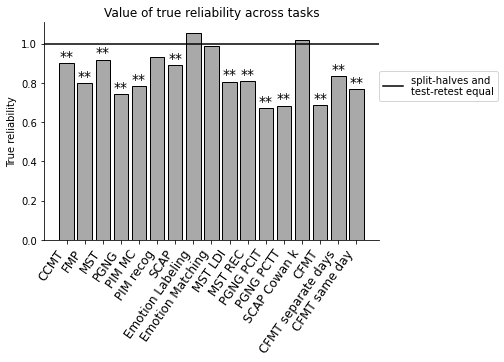

,task,true_reliability,L,mean_error,SD_error,5_percentile,95_percentile,1_percentile,99_percentile,star_gazing,nice_name
0,CCMT,0.898219,36,0.999319,0.020309,0.966295,1.030160,0.946739,1.046845,**,CCMT
1,FMP,0.799323,90,1.001036,0.025197,0.958697,1.041499,0.941412,1.052994,**,FMP
2,MST,0.917638,160,1.001305,0.018981,0.969669,1.031101,0.953693,1.042688,**,MST
3,PGNG,0.740899,58,1.000234,0.013779,0.977253,1.022487,0.967783,1.031301,**,PGNG
4,PIM_MC,0.784782,48,0.999878,0.007707,0.986676,1.012508,0.980843,1.016272,**,PIM MC
5,PIM_recog,0.932310,24,1.004111,0.073243,0.887378,1.124838,0.834413,1.169887,,PIM recog
6,SCAP,0.891067,36,0.998455,0.028744,0.947158,1.044845,0.929663,1.063111,**,SCAP
7,emotion_labelling,1.054473,22,1.003158,0.067339,0.892518,1.112562,0.851509,1.153587,,Emotion Labeling
8,emotion_matching,0.984915,30,1.007440,0.097706,0.843811,1.173610,0.780826,1.248060,,Emotion Matching
9,MST_LDI,0.806370,32,1.000320,0.038998,0.933813,1.059810,0.904366,1.088605,**,MST LDI


In [59]:
df_true_reliabilities_task_specific = pd.DataFrame()

# for i,task in enumerate(task4analysis):
for i,task in enumerate(dic_all_tasks_and_measures.keys()):
    # check if there was a significant learning, if yes, remove
    if task in significant_learning_exclude:
        continue
    else:
    
        if f'{task}_battery_real' in dic_reliability_error_task_specific.keys():
            # 
            tmp_error_dic = dic_reliability_error_task_specific[f'{task}_battery_real'][max([x for x in dic_reliability_error_task_specific[f'{task}_battery_real'].keys() if isinstance(x, (int, np.integer))])]

            # select the corresponding dic -- choose task and cleaning condition
            tmp_dic = dic_all_tasks_and_measures[task]

            value = max(set(tmp_dic['n_trials_list_orig'])&set(tmp_dic['n_trials_list_rep'])&set(tmp_dic['n_trials_list_orig_vs_rep']))
            # get index where it is closes to the max that all arrays share
            index = np.abs(tmp_dic['n_trials_list_orig'] - value).argmin()
            index_orig_vs_rep = np.abs(tmp_dic['n_trials_list_orig_vs_rep'] - value).argmin()

            # PGNG has an issue that the error is calculated for 58 trials but the reliability for 55, I decided to skip this issue for now and consider them the same
            # similarly fo CFMT, it is 32 and error is for 36 trials, I consider them the same
            if task != "PGNG" and "CFMT" not in task:
                assert tmp_dic['n_trials_list_orig'][index] == value == tmp_dic['n_trials_list_orig_vs_rep'][index_orig_vs_rep] == tmp_error_dic['n_trials_list_orig'][0]

            true_rel = get_true_correlation(np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1)[index_orig_vs_rep],
                             np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1)[index], 
                             np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1)[index])
            print(f"True reliability for {task} at L={tmp_dic['n_trials_list_orig'][index]}: {true_rel:.3f}")

            # get the error
            r_xy_array = tmp_error_dic['r_xy_array']
            # save
            if task == "SCAP_Cowan":
                task = "SCAP_Cowan_k"
            df_true_reliabilities_task_specific = pd.concat([df_true_reliabilities_task_specific, pd.DataFrame({
                'task': [task],
                'true_reliability': [true_rel],
                'L': value,
                'mean_error': [r_xy_array.mean()],
                'SD_error': [r_xy_array.std()],
                '5_percentile': [np.percentile(r_xy_array, 5)],
                '95_percentile': [np.percentile(r_xy_array, 95)],
                '1_percentile': [np.percentile(r_xy_array, 1)],
                '99_percentile': [np.percentile(r_xy_array, 99)],
            })])

        else:
            print(f'--- {task} is missing in the dic')
    
df_true_reliabilities_task_specific.reset_index(inplace=True,drop=True)

# add column with stars
conditions = [
    (df_true_reliabilities_task_specific['true_reliability'] < df_true_reliabilities_task_specific['1_percentile']) | (df_true_reliabilities_task_specific['true_reliability'] > df_true_reliabilities_task_specific['99_percentile']),
    (df_true_reliabilities_task_specific['true_reliability'] < df_true_reliabilities_task_specific['5_percentile']) | (df_true_reliabilities_task_specific['true_reliability'] > df_true_reliabilities_task_specific['95_percentile'])
]

choices = ['**', '*']
df_true_reliabilities_task_specific['star_gazing'] = np.select(conditions, choices, default='')


# add a nice name for plots
df_true_reliabilities_task_specific["nice_name"] = df_true_reliabilities_task_specific["task"].apply(human_label)


## Plot
colours_confidence = sns.color_palette('YlOrBr')[2::2]

fig, ax = plt.subplots(1,1, figsize=(6,4))

# ax.bar(task4analysis, true_reliabilities, color='darkgrey', edgecolor='k')
ax.bar(df_true_reliabilities_task_specific["nice_name"], df_true_reliabilities_task_specific["true_reliability"], color='darkgrey', edgecolor='k')
ax.set_ylabel('True reliability')
# ax.set_xlabel('Task')

ax.set_xticks(np.arange(len(df_true_reliabilities_task_specific["task"])))
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, ha='right', size=12)


# add stars for values outside the 1-99 and 5-95 percentile range
for i, (value, lower1, upper1, lower2, upper2) in enumerate(zip(df_true_reliabilities_task_specific['true_reliability'], df_true_reliabilities_task_specific['1_percentile'], df_true_reliabilities_task_specific['99_percentile'], df_true_reliabilities_task_specific['5_percentile'], df_true_reliabilities_task_specific['95_percentile'])):
    if value < lower1 or value > upper1:
        ax.text(i, value, '**', ha='center', va='bottom', color='k', fontsize=14)
    elif value < lower2 or value > upper2:
        ax.text(i, value, '*', ha='center', va='bottom', color='k', fontsize=14)

ax.axhline(1, color='k', label='split-halves and\ntest-retest equal')



sns.despine()

plt.legend(loc='upper right', bbox_to_anchor=(1.37,.8))

plt.title(f"Value of true reliability across tasks")
plt.show()



df_true_reliabilities_task_specific

In [60]:
print(f'mean test-retest = {df_true_reliabilities_task_specific["mean_error"].mean()}\nSD test-retest = {df_true_reliabilities_task_specific["mean_error"].std()}')



mean test-retest = 1.001299320501941
SD test-retest = 0.0021423521832057944


In [61]:
# define the order of columns based on reliability in Figure 2
tick_order_cat = pd.CategoricalDtype(categories=[
 'Emotion Matching',
 'SCAP Cowan k',
 'PIM recog',
 'Emotion Labeling',
 'GFMT',
 "N Back d'",
 'Car Matching',
 'VET',
 'MST LDI',
 'CFMT',
 'SCAP',
 'FMP',
 'PGNG PCIT',
 'N Back',
 'CCMT',
 'MST REC',
 'MST',
 'PGNG',
 'PGNG PCTT',
 'PIM MC'], ordered=True)

# convert column Categorical data type
df_true_reliabilities_task_specific['sorted_col'] = df_true_reliabilities_task_specific['nice_name'].astype(tick_order_cat)

# Sort the DataFrame based on the specified column
df_true_reliabilities_task_specific.sort_values(by='sorted_col', inplace=True)
df_true_reliabilities_task_specific.reset_index(drop=True, inplace=True)

df_true_reliabilities_task_specific

,task,true_reliability,L,mean_error,SD_error,5_percentile,95_percentile,1_percentile,99_percentile,star_gazing,nice_name,sorted_col
0,emotion_matching,0.984915,30,1.007440,0.097706,0.843811,1.173610,0.780826,1.248060,,Emotion Matching,Emotion Matching
1,SCAP_Cowan_k,1.019656,10,1.001350,0.071728,0.881120,1.121751,0.835662,1.177822,,SCAP Cowan k,SCAP Cowan k
2,PIM_recog,0.932310,24,1.004111,0.073243,0.887378,1.124838,0.834413,1.169887,,PIM recog,PIM recog
3,emotion_labelling,1.054473,22,1.003158,0.067339,0.892518,1.112562,0.851509,1.153587,,Emotion Labeling,Emotion Labeling
4,MST_LDI,0.806370,32,1.000320,0.038998,0.933813,1.059810,0.904366,1.088605,**,MST LDI,MST LDI
5,CFMT_origFmonth,0.687657,32,1.000592,0.036930,0.934894,1.055566,0.905826,1.076656,**,CFMT,CFMT
6,SCAP,0.891067,36,0.998455,0.028744,0.947158,1.044845,0.929663,1.063111,**,SCAP,SCAP
7,FMP,0.799323,90,1.001036,0.025197,0.958697,1.041499,0.941412,1.052994,**,FMP,FMP
8,PGNG_PCIT,0.671961,12,0.999656,0.025993,0.954384,1.037138,0.927438,1.051119,**,PGNG PCIT,PGNG PCIT
9,CCMT,0.898219,36,0.999319,0.020309,0.966295,1.030160,0.946739,1.046845,**,CCMT,CCMT


## CanD
[top](#top)

{'name': 'Arial'}
Reliability longitudinal FMP, N=183, removed outliers >2SD
Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>2SD
N_sep=77, N_same=42, N_7m=79, n$_{\mathrm{concat}}$=144, n$_{\mathrm{Aus}}$=72, n$_{\mathrm{F}}$=72, n_iter=50
Value of true reliability across tasks


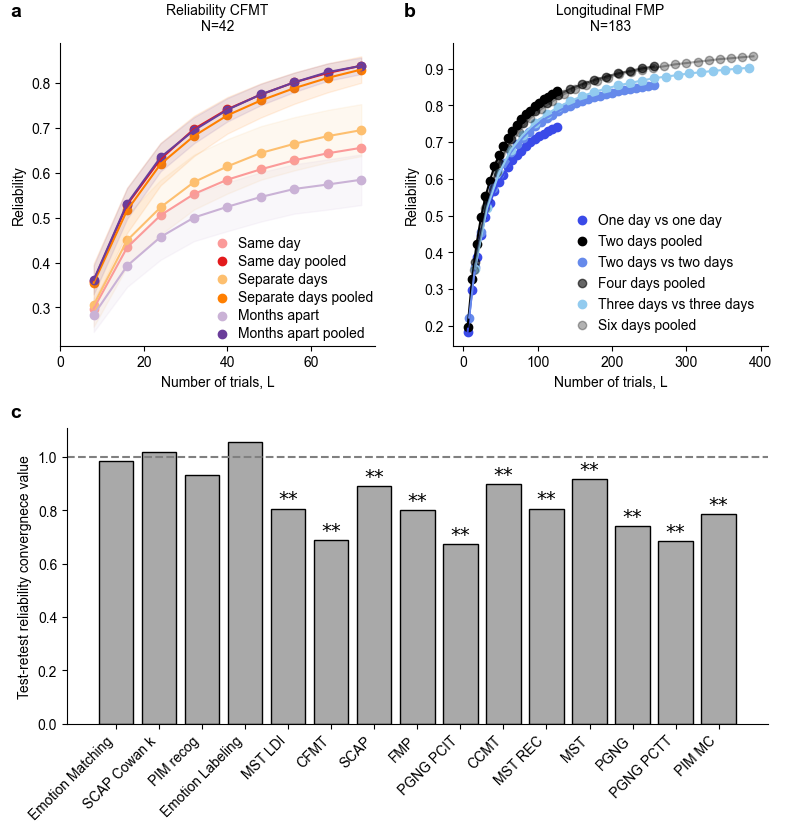

In [62]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 13+8
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10)

# letters
c.add_text("a", Point(.02, 0.985), weight="bold", size=font_size)
c.add_text("b", Point(.52, 0.985), weight="bold", size=font_size)
c.add_text("c", Point(.02, 0.5), weight="bold", size=font_size)
           
# titles
titles = [f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', f"""Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}""",
         'Value of true reliability across tasks']
# c.add_text(titles[0], Point(.27, 0.947), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panels A, B
top_offset = 1.1
bottom_offset = 0.2
bottom_offset_tasks = 2.6

middle = 12

# add a 1x2 grid
left_offset = 1.53
hsb = 2.4 #half_space_between - horizontal
vsb = 2 #half_space_between - vertical
c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, middle+bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"))


# # bottom row, panel C
left_offset_tasks = 1.7
hsb_tasks = 2.7 #half_space_between - horizontal
vsb_tasks = .3 #half_space_between - vertical

# add a 2x5 grid
c.add_grid(["significance"], 1, Point(left_offset_tasks, bottom_offset_tasks, "cm"), Point(a-0.5, b-middle+top_offset, "cm"), spacing=Vector(vsb_tasks, hsb_tasks, "cm"), unitname="grid")



# define colours
palette = sns.color_palette('blend:lightskyblue,blue', desat=.8, n_colors=12)
colour_day3and5 = palette[8]
colour_day35and24 = palette[4]
colour_day135and246 = palette[0]

palette_tasks = sns.cubehelix_palette(n_colors=9, start=2.5)
colour_day1 = palette_tasks[3]
colour_day2 = palette_tasks[6]
colour_day1vsday = palette[6]



pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
# pallette_CFMT_same = [pallette_CFMT[4], pallette_CFMT[5]]
pallette_CFMT_separate = pallette_CFMT[2:]


# define if to plot the error in CFMT
plot_error = True
# define if to have the frame on the legend
frame_on = False


############################ PLOT CFMT
# plot same day, Aus2 vs F2
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Same day'),
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers, 'Same day pooled'),
]):
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=1), label=f'{label}', color=pallette_CFMT[i])
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[i])

# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'Separate days pooled'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, 'Months apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, 'Months apart pooled'),
]):
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i])
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i], label=f'{label}')
    
    if plot_error:
        c.ax('CFMT').fill_between(
            x_list,
            np.nanmean(arr, axis=0)-np.nanstd(arr, axis=0),
            np.nanmean(arr, axis=0)+np.nanstd(arr, axis=0),
    #         label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}',
            color=pallette_CFMT_separate[i], alpha=0.1,
        )

# deal with legend
if frame_on:
    c.ax('CFMT').legend(loc="lower right", columnspacing=0.01, labelspacing=0.3, borderpad=0.3, handletextpad=0.1)
else:
    c.ax('CFMT').legend(loc="lower right", columnspacing=0.01, labelspacing=0.3, borderpad=0.3, handletextpad=0.1, bbox_to_anchor=(1.03,-.02), frameon=False)

c.ax('CFMT').set_ylabel('Reliability')
c.ax('CFMT').set_xlabel('Number of trials, L')

c.add_text(f"Reliability CFMT\nN={min(N_CFMT_AusF_nooutliers, N_CFMT_Aus2F2_nooutliers, N_CFMT_origFmonth_nooutliers)}", 
           Point(.5, 1.08, "axis_CFMT"))


# have the x-axis going from 0
c.ax('CFMT').set_xlim(left=0)

############################ PLOT FMP
c.ax('FMP').scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'One day vs one day', color=colour_day3and5)
c.ax('FMP').plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)

# add the full concatenated 2 forms
c.ax('FMP').scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'Two days pooled', color='k')
c.ax('FMP').plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


#######
c.ax('FMP').scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'Two days vs two days', color=colour_day35and24)
c.ax('FMP').plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)

# add the full concatenated 4 forms
c.ax('FMP').scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'Four days pooled', color='k', alpha=0.6)
c.ax('FMP').plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


#######
c.ax('FMP').scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'Three days vs three days', color=colour_day135and246)
c.ax('FMP').plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)

# add the full concatenated 6 forms
c.ax('FMP').scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'Six days pooled', color='k', alpha=0.3)
c.ax('FMP').plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)


## polish
c.ax('FMP').legend(loc="lower right", columnspacing=0.01, labelspacing=.5, borderpad=0.5, handletextpad=0.1, frameon=frame_on)

c.ax('FMP').set_ylabel('Reliability')
c.ax('FMP').set_xlabel('Number of trials, L')

c.add_text(f"Longitudinal FMP\nN={N_FMP_long_nooutliers_all_days}", Point(.5, 1.08, "axis_FMP"))


######### panel C
# select data
data_significance = df_true_reliabilities_task_specific.loc[~df_true_reliabilities_task_specific["task"].str.contains("day")]
c.ax('significance').bar(data_significance["nice_name"], data_significance["true_reliability"], color='darkgrey', edgecolor='k')
c.ax('significance').set_ylabel('Test-retest reliability convergnece value')

c.ax('significance').set_xticks(np.arange(len(data_significance["task"])))
c.ax('significance').set_xticklabels(c.ax('significance').get_xticklabels(), rotation=45, ha='right', size=12)


# add stars for values outside the 1-99 and 5-95 percentile range
for i, (value, lower1, upper1, lower2, upper2) in enumerate(zip(data_significance['true_reliability'], data_significance['1_percentile'], data_significance['99_percentile'], data_significance['5_percentile'], data_significance['95_percentile'])):
    if value < lower1 or value > upper1:
        c.ax('significance').text(i, value, '**', ha='center', va='bottom', color='k', fontsize=14)
    elif value < lower2 or value > upper2:
        c.ax('significance').text(i, value, '*', ha='center', va='bottom', color='k', fontsize=14)

c.ax('significance').axhline(1, linestyle='--', color='gray')#, label='split-halves and\ntest-retest equal')

### make it nice
for ax in c.axes.values():
    sns.despine(ax=ax)

    
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "Fig7", 'Figure_7.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig7", 'Figure_7.pdf'), dpi=300)#, bbox_inches="tight")

#### CanD curves
[top](#top)

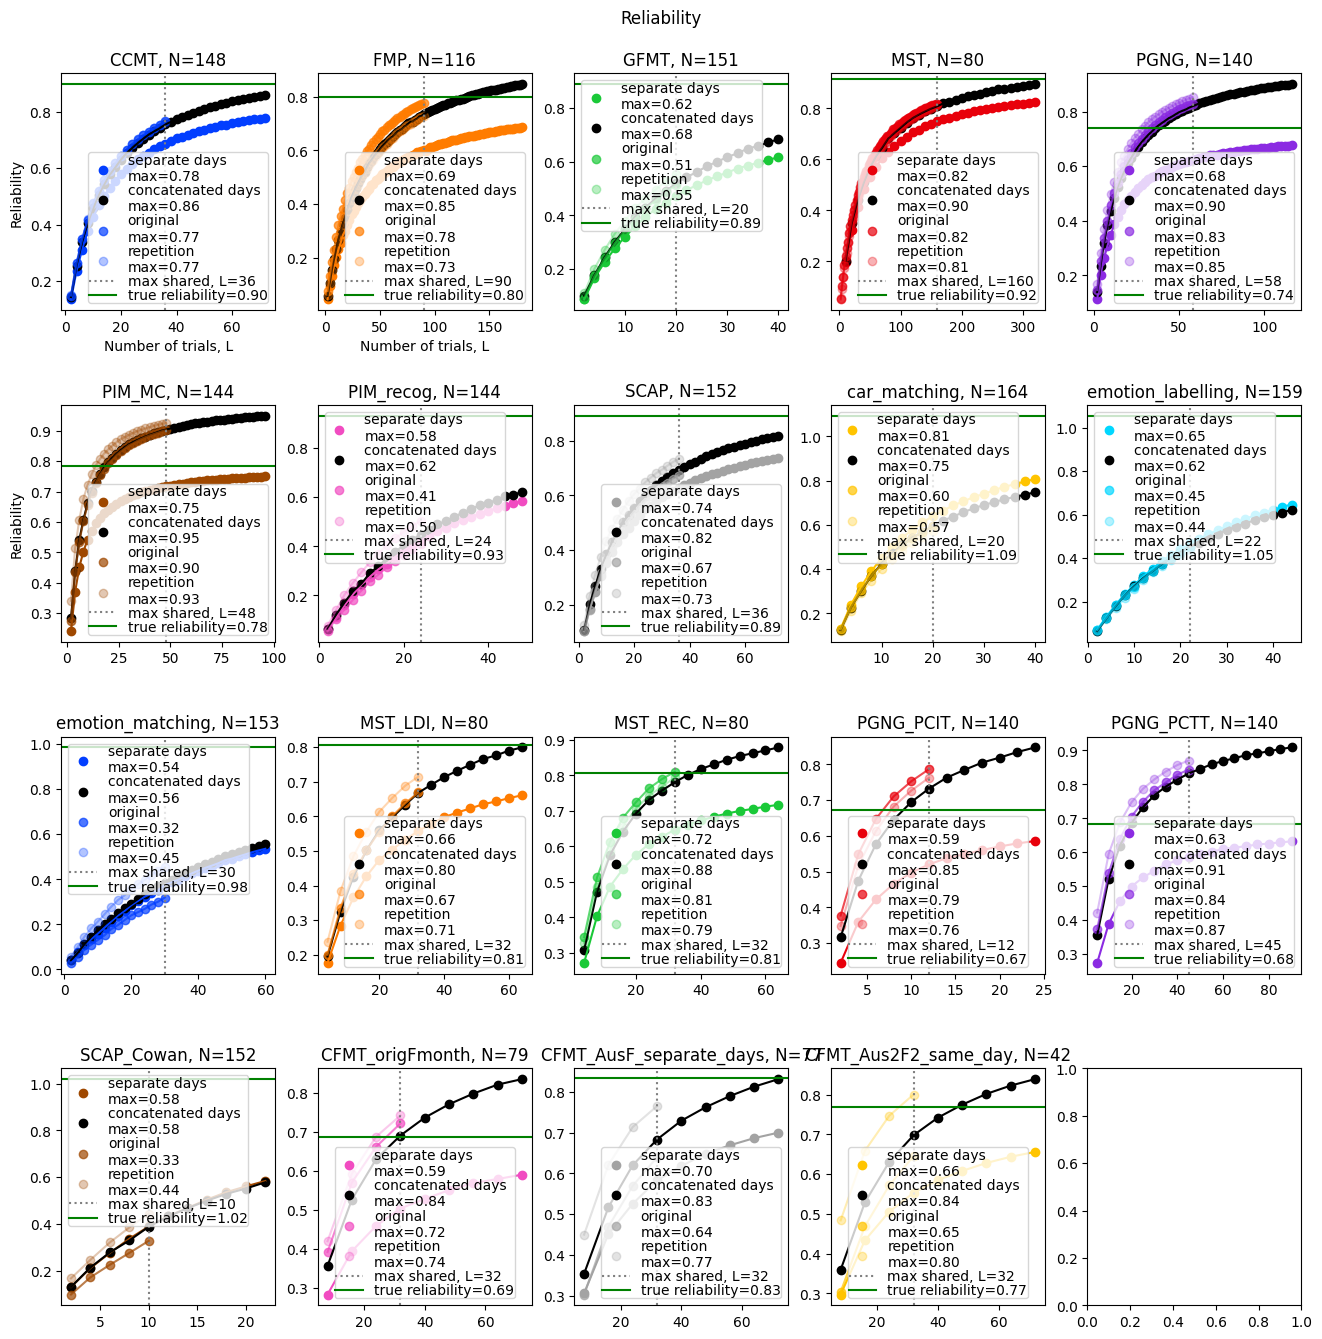

In [63]:

palette = sns.color_palette("bright", n_colors=len(dic_all_tasks_and_measures.keys()), as_cmap=False)

fig, axs = plt.subplots(4,(len(dic_all_tasks_and_measures.keys())+1)//4, figsize=(16,16))

plt.subplots_adjust(hspace=0.4)

for (i, ax), task in zip(enumerate(axs.flatten()), dic_all_tasks_and_measures.keys()):
    # select the corresponding dic -- choose task and cleaning condition
    tmp_dic = dic_all_tasks_and_measures[task]
    ## plot long arrays
    ax.scatter(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), label=f'separate days\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig_vs_rep"], axis=1).max():.2f}', color=palette[i])
    ax.plot(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), color=palette[i])

    # add the full concatenated forms
    ax.scatter(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), label=f'concatenated days\nmax={np.nanmean(tmp_dic["array_corr_fxn_concat"], axis=1).max():.2f}', color='k')
    ax.plot(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), color='k')


    if run_short_arrays:
        ## plot short arrays
        ax.scatter(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=palette[i], alpha=0.7, label=f'original\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig"], axis=1).max():.2f}')
        ax.plot(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=palette[i], alpha=0.7)
        # plot rep days
        ax.scatter(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=palette[i], alpha=0.3, label=f'repetition\nmax={np.nanmean(tmp_dic["array_corr_fxn_rep"], axis=1).max():.2f}')
        ax.plot(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=palette[i], alpha=0.3)

        # Add plot for the expected correlation
        # check that the x ranges are the same
        assert np.array_equal(tmp_dic['n_trials_list_orig'], tmp_dic['n_trials_list_rep'])
        assert np.array_equal(tmp_dic['n_trials_list_concat'], tmp_dic['n_trials_list_orig_vs_rep'])

        # figure out maximal L that we have in both curves
        max_L = max(set(tmp_dic['n_trials_list_orig'])&set(tmp_dic['n_trials_list_orig_vs_rep']))
        # get the reliabilities
        r_xx_prime = np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1)[np.argwhere(tmp_dic['n_trials_list_orig']==max_L)[0][0]]
        r_yy_prime = np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1)[np.argwhere(tmp_dic['n_trials_list_rep']==max_L)[0][0]]
        r_xy_prime = np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1)[np.argwhere(tmp_dic['n_trials_list_orig_vs_rep']==max_L)[0][0]]

        # get the true correlation
        r_xy = get_true_correlation(r_xy_prime, r_xx_prime, r_yy_prime)
        
        # plot
        ax.axvline(max_L, c='grey', linestyle=':', label=f'max shared, L={max_L}')
        ax.axhline(r_xy, c='g', linestyle='-', label=f'true reliability={r_xy:.2f}')
    
    
    ax.legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05)
    ax.set_title(f'{task}, N={tmp_dic["N"]}')



axs[0,0].set_ylabel('Reliability')
axs[1,0].set_ylabel('Reliability')

# for i in range(len(task4analysis)//2):
for i in range(len(task4analysis)//4):
    axs[0,i].set_xlabel('Number of trials, L')

plt.suptitle(f'Reliability', y=.92)
plt.show()


{'name': 'Arial'}
Reliability curves: reliability stability across visits per task


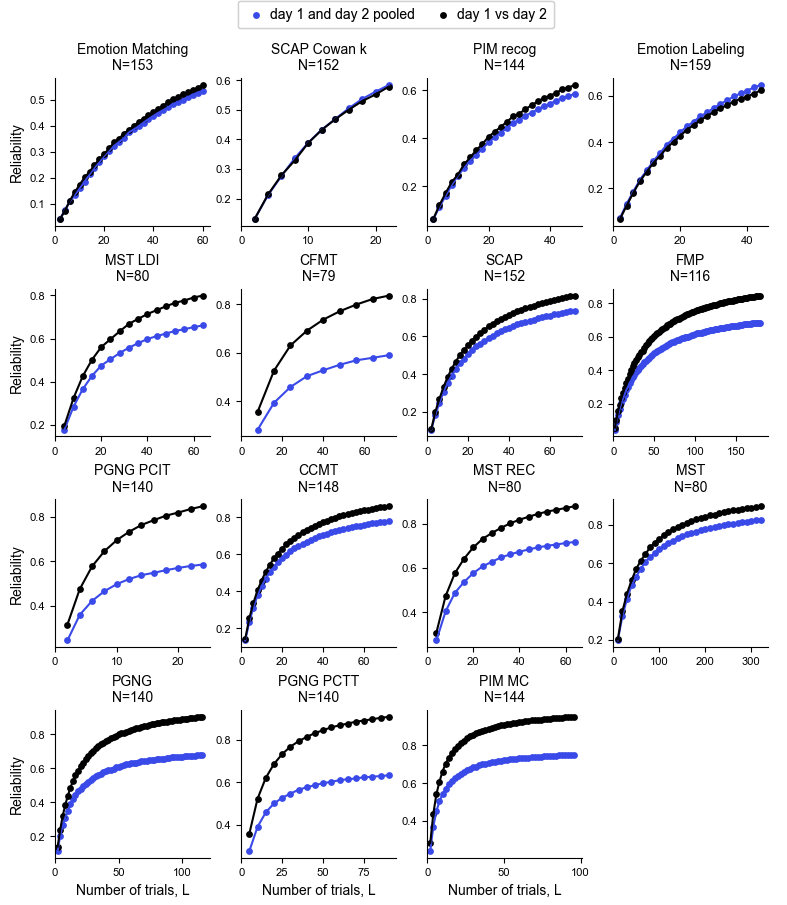

In [64]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker
from plot_functions import sharey_ax

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=8

plot_short_arrays = False

if plot_short_arrays:
    palette_tasks = sns.cubehelix_palette(n_colors=9, start=2.5)
    colour_day1 = palette_tasks[3]#'cornflowerblue'#palette_tasks[6]
    colour_day2 = palette_tasks[6]#palette_tasks[9]#'saddlebrown'#palette_tasks[2]
    colour_day1vsday = palette[6]#'cornflowerblue'#palette[6]#palette_tasks[0]
    
    legend_labels = ['day 1', 'day 2', 'day 1 and day 2 pooled', 'day 1 vs day 2', 'true reliability']
else:
    # in case it's not defined, this is the definition
#     palette = sns.color_palette('blend:lightskyblue,blue', desat=.8, n_colors=12)
#     colour_day3and5 = palette[8]
    colour_day1vsday = colour_day3and5
    
    legend_labels = ['day 1 and day 2 pooled', 'day 1 vs day 2']
    
    
    
assert len(dic_all_tasks_and_measures.keys()) == 16+3

scatter_size = 15

# CanD
a = 20
b = 23
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10, ticksize=legend_size)
           
# titles
titles = ["Reliability curves: reliability stability across visits per task"]
# c.add_text(titles[0], Point(.5, 0.98), size=font_size)
for title in titles:
    print(title)

# ### GRID
top_offset = 2.
bottom_offset = 1.2
right_offset = 1.4
hsb = 1.6 #half_space_between - horizontal
vsb = .8 #half_space_between - vertical

# define tasks to plot
tasks2plot = [x for x in dic_all_tasks_and_measures.keys() if x not in significant_learning_exclude and x not in ['CFMT_AusF_separate_days', 'CFMT_Aus2F2_same_day']]

tasks2plot_ordered = [
    'emotion_matching',
    'SCAP_Cowan',
    'PIM_recog',
    'emotion_labelling',
    'MST_LDI',
    'CFMT_origFmonth',
    'SCAP',
    'FMP',
    'PGNG_PCIT',
    'CCMT',
    'MST_REC',
    'MST',
    'PGNG',
    'PGNG_PCTT',
    'PIM_MC',
]

assert set(tasks2plot) == set(tasks2plot_ordered)

# add a 5x2 grid
# c.add_grid([f"p{i}" for i in range(len(dic_all_tasks_and_measures.keys())-2-len(significant_learning_exclude))], 4, 
c.add_grid([f"p{i}" for i in range(len(tasks2plot))], 4, 
           Point(right_offset, bottom_offset, "cm"), 
           Point(a-.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")


######### panel A
for (i, ax), task in zip(enumerate(c.axes.values()), tasks2plot_ordered):#dic_all_tasks_and_measures.keys()):

    # select the corresponding dic -- choose task and cleaning condition
    tmp_dic = dic_all_tasks_and_measures[task]

    if plot_short_arrays:
        ## plot short arrays
        ax.scatter(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1, label=f'original\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig"], axis=1).max():.2f}', s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1)
        # plot rep days
        ax.scatter(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2, label=f'repetition\nmax={np.nanmean(tmp_dic["array_corr_fxn_rep"], axis=1).max():.2f}', s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2)

        ## plot long arrays
        ax.scatter(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), label=f'separate days\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig_vs_rep"], axis=1).max():.2f}', color=colour_day1vsday, s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), color=colour_day1vsday)

        # add the full concatenated forms
        ax.scatter(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), label=f'concatenated days\nmax={np.nanmean(tmp_dic["array_corr_fxn_concat"], axis=1).max():.2f}', color='k', s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), color='k')

        
        # Add plot for the expected correlation
        # check that the x ranges are the same
        assert np.array_equal(tmp_dic['n_trials_list_orig'], tmp_dic['n_trials_list_rep'])
        assert np.array_equal(tmp_dic['n_trials_list_concat'], tmp_dic['n_trials_list_orig_vs_rep'])

        # figure out maximal L that we have in both curves
        max_L = max(set(tmp_dic['n_trials_list_orig'])&set(tmp_dic['n_trials_list_orig_vs_rep'])) #max(np.intersect1d(tmp_dic['n_trials_list_orig'], tmp_dic['n_trials_list_orig_vs_rep']))
        # get the reliabilities
        r_xx_prime = np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1)[np.argwhere(tmp_dic['n_trials_list_orig']==max_L)[0][0]]
        r_yy_prime = np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1)[np.argwhere(tmp_dic['n_trials_list_rep']==max_L)[0][0]]
        r_xy_prime = np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1)[np.argwhere(tmp_dic['n_trials_list_orig_vs_rep']==max_L)[0][0]]

        # get the true correlation
        r_xy = get_true_correlation(r_xy_prime, r_xx_prime, r_yy_prime)
        
        # plot
        ax.axhline(r_xy, c='g', linestyle='-', label=f'true reliability={r_xy:.2f}')
    
    else:
        ## plot long arrays
        ax.scatter(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), label=f'separate days\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig_vs_rep"], axis=1).max():.2f}', color=colour_day1vsday, s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), color=colour_day1vsday)

        # add the full concatenated forms
        ax.scatter(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), label=f'concatenated days\nmax={np.nanmean(tmp_dic["array_corr_fxn_concat"], axis=1).max():.2f}', color='k', s=scatter_size)
        ax.plot(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), color='k')
 

    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
    elif 'Cowan' in ax_title:
        ax_title += " k"
    elif ax_title == 'CFMT origFmonth':
        ax_title = 'CFMT'

    ax.set_title(f'{ax_title}\nN={tmp_dic["N"]}')

    
    # deal with labels
    if i>= len(dic_all_tasks_and_measures.keys())-4-3:
        ax.set_xlabel("Number of trials, L")
    else:
        ax.set_xlabel("")
    
    if i%4==0:
        ax.set_ylabel("Reliability")
        source_ax = ax
    else:
        ax.set_ylabel("")

    if i == 1:
        legend1 = ax.legend(ax.get_legend_handles_labels()[0],
                            legend_labels, bbox_to_anchor=(1, 1.3),
                            borderpad=.6, handletextpad=.3, columnspacing=1.5, loc='lower center', ncols=5,
                            fontsize=legend_size, labelspacing=0.8, scatteryoffsets=[0.5])
        ax.add_artist(legend1)

    
    sns.despine(ax=ax)
    
    ax.set_xlim(left=0)

    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
# #
c.save(os.path.join(path_figures, "SI", 'SI_Figure_10.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "SI", 'SI_Figure_10.pdf'), dpi=300)#, bbox_inches="tight")

#### CanD scatterplots
[top](#top)

PIM_MC
Starting with N=152 subjects.
diff:2SD, perf:None
Dropping 8 outliers for score difference
Total number of trials is 96.
Total number of trials is 96.
Total number of trials is 192.
MST
Starting with N=84 subjects.
diff:2SD, perf:None
Dropping 4 outliers for score difference
Total number of trials is 320.
Total number of trials is 320.
Total number of trials is 640.
PGNG
Starting with N=152 subjects.
diff:2SD, perf:None
Dropping 12 outliers for score difference
Total number of trials is 116.
Total number of trials is 116.
Total number of trials is 232.
PIM_recog
Starting with N=152 subjects.
diff:2SD, perf:None
Dropping 8 outliers for score difference
Total number of trials is 48.
Total number of trials is 48.
Total number of trials is 96.
emotion_matching
Starting with N=161 subjects.
diff:2SD, perf:None
Dropping 8 outliers for score difference
Total number of trials is 61.
Total number of trials is 61.
Total number of trials is 122.
CCMT
Starting with N=154 subjects.
diff:2SD,

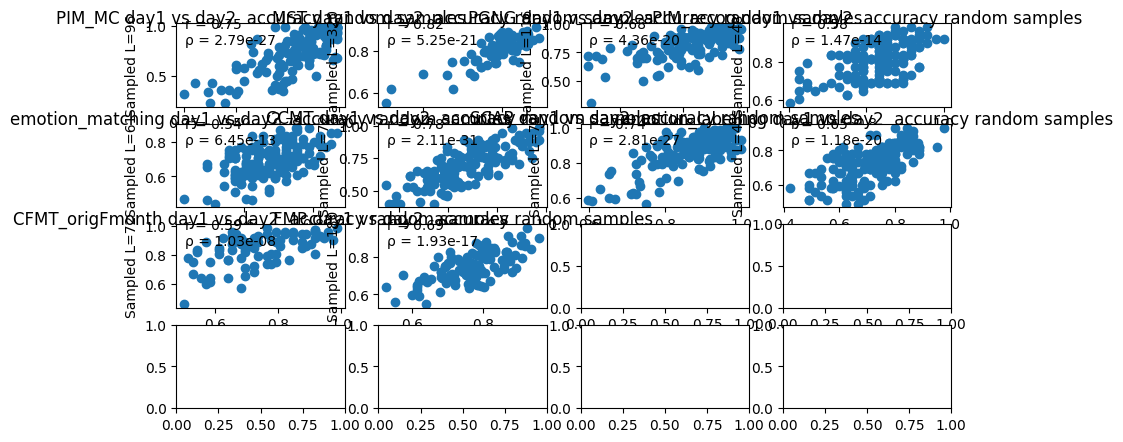

In [65]:
dic_scatterplots = {}

# how many samples we want to correlate
n_repeats = 1

# start the timer
start = time.time()

fig, axs = plt.subplots(4, 4, figsize=(10,5))

# run without nback as it is not behaving well
# for task in task4analysis:
for task, ax in zip((set(task4analysis)-set(significant_learning_exclude))|set(['CFMT_origFmonth']), axs.flatten()):
# #     start the timer
#     start_task = time.time()

    # be sure and clean
    df_temp = None
    df_temp_cleaned = None
    print(task)
    
    # add CFMT orig vs F months apart
    if task == 'CFMT_origFmonth':
        x, y, n_trials_list = calculate_reliability_between_two_groups_scatterplots(dic_all_tasks_and_measures['CFMT_origFmonth']['all_trials_reshaped_orig'], 
                                                                                    dic_all_tasks_and_measures['CFMT_origFmonth']['all_trials_reshaped_rep'], 
                                                                                    dic_all_tasks_and_measures['CFMT_origFmonth']['total_n_trials_orig']+dic_all_tasks_and_measures['CFMT_origFmonth']['total_n_trials_rep'], 
                                                                                    n_repeats=n_repeats, test=task+' day1 vs day2 ', step=dic_all_tasks_and_measures['CFMT_origFmonth']['total_n_trials_orig'], axs=ax)
    else:
        # extract data
        if task == "nback_lvl2":
            df_temp = [x for x in dataframe_list if x.task.str.contains('nback').all()][0]
            df_temp = df_temp.loc[df_temp["level"]==2]
        else:
            df_temp = [x for x in dataframe_list if x.task.str.contains(task).all()][0]

        if task == "PIM_MC":
            # merge and flat all the cols
            df_temp = pd.melt(df_temp[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                              id_vars=['userID', 'form'], value_name='correct')

        # check that the forms are there
        assert set(["original", "repetition"]) == set(df_temp["form"].unique())
        print(f"Starting with N={df_temp['userID'].unique().size} subjects.")

        # go over all conditions of cleaning
        for diff_c, perf_c in cleaning_conditions:
            # copy the df to be able to clean it
            df_temp_cleaned = df_temp.copy()

            # define condition
            condition = f'diff:{diff_c}, perf:{perf_c}'
            print(condition)

            # define outliers that we want to drop on accuracy
            if perf_c is not None:
                # check if it's SD or %
                if 'SD' in perf_c:
                    # find the SD and select the SD
                    std_thr_acc = float(perf_c.strip('SD'))
                    # add label
                    condition += '_bottom'

                    for form in ["original", "repetition"]:        
                        # compute the mean, use the original dataset and not the one that will already be partially cleaned
                        tmp_series = df_temp.loc[df_temp["form"]==form].groupby(['userID']).correct.mean()
                        mu_acc = tmp_series.mean() #df_temp['correct'].mean()
                        std_acc = tmp_series.std() #df_temp.groupby(['userID']).correct.mean().std()
                        outliers_acc = set(tmp_series[tmp_series<mu_acc-std_acc*std_thr_acc].dropna().index)
                        # drop the outliers form the cleaned dataset
                        df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                        print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')

                elif '%' in perf_c:
                    # drop the perf_c percent of the scores
                    std_thr_acc = float(perf_c.strip('%'))/100
                    for form in ["original", "repetition"]:        
                        # take the n smallest scores where n is proportional to the threshold
                        outliers_acc = tmp_series.nsmallest(int(np.round(len(tmp_series)*std_thr_acc))).index
                        # drop the outliers form the cleaned dataset
                        df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                        print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')

                else:
                    raise ValueError(f'Provided value cannot be processed: {perf_c}')

            # there is no else because if it is None, then we are not cleaning which means that we continue with the original dataset


            # define outliers that we want to drop on score difference between visits
            if diff_c is not None:            
                # compute the score difference
                tmp_score_diff = df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()

                # check if it's SD or %
                if 'SD' in diff_c:
                    std_thr = float(diff_c.strip('SD'))
                    # drop participants whose difference in score on first and second step is large
                    mu = tmp_score_diff.mean()[0]
                    std = tmp_score_diff.std()[0]
                    outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]

                elif '%' in diff_c:
                    # drop the perf_c percent of the scores
                    std_thr = float(diff_c.strip('%'))/100

                    # take the n larges differences in scores where n is proportional to the threshold
                    outliers = tmp_score_diff.abs().nlargest(int(np.round(len(tmp_score_diff)*std_thr)), 'correct').index
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]


                print(f'Dropping {len(outliers)} outliers for score difference')


            # extract to arrays
            N_temp = df_temp_cleaned['userID'].unique().size

            ## original
            # max number of trials
            total_n_trials_orig = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_orig = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], total_n_trials_orig, measure="correct")

            ## repetition
            # max number of trials
            total_n_trials_rep = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_rep = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], total_n_trials_rep, measure="correct")


            ## concat
            # max number of trials
            total_n_trials_concat = check_df_get_numbers(df_temp_cleaned.loc[:, ['userID', 'correct']], N_temp)
            # extract the data
            all_trials_reshaped_concat = extract_data(df_temp_cleaned.loc[:, ['userID', 'correct']], total_n_trials_concat, measure="correct")

            # define step, take only one
            step = total_n_trials_concat//2


            x, y, n_trials_list = calculate_reliability_between_two_groups_scatterplots(all_trials_reshaped_orig, all_trials_reshaped_rep, total_n_trials_orig+total_n_trials_rep, n_repeats=n_repeats, test=task+' day1 vs day2 ', step=step, axs=ax)

    dic_scatterplots[task] = {'x':x, 'y':y, 'L': n_trials_list}


{'name': 'Arial'}
Reliability scatterplots: reliability stability across visits per task


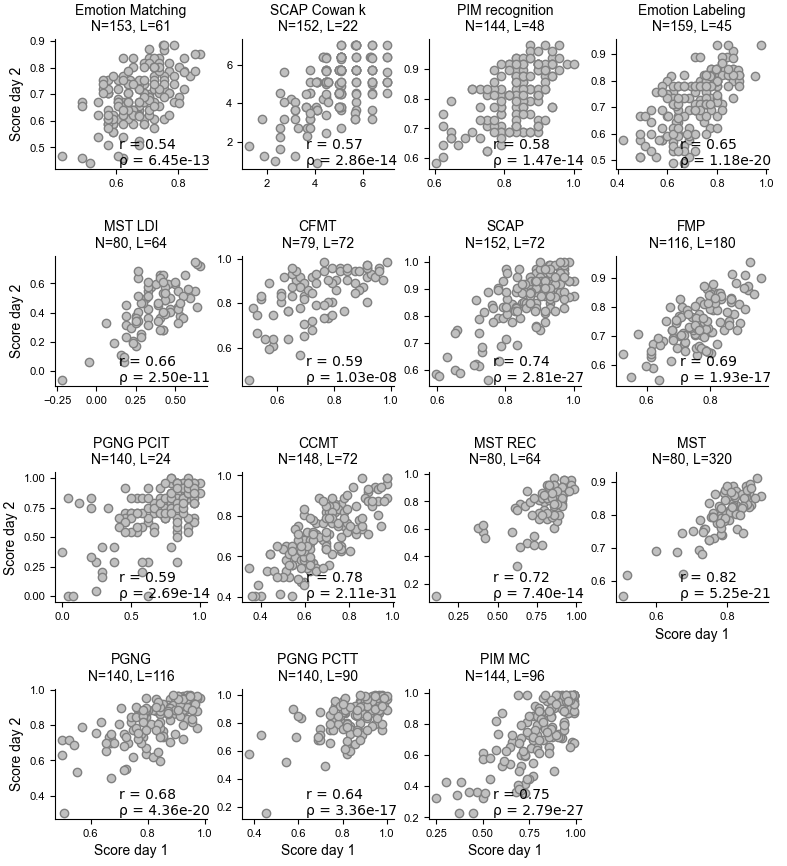

In [66]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker
from plot_functions import sharey_ax

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=8

assert len(dic_all_tasks_and_measures.keys()) == 16+3


# CanD
a = 20
b = 22
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10, ticksize=legend_size)
           
# titles
titles = ["Reliability scatterplots: reliability stability across visits per task"]
# c.add_text(titles[0], Point(.5, 0.98), size=font_size)
for title in titles:
    print(title)

# ### GRID
top_offset = 1.
bottom_offset = 1.2
right_offset = 1.4
hsb = 2.2 #half_space_between - horizontal
vsb = .9 #half_space_between - vertical


# define tasks to plot
tasks2plot = [x for x in dic_all_tasks_and_measures.keys() if x not in significant_learning_exclude and x not in ['CFMT_AusF_separate_days', 'CFMT_Aus2F2_same_day']]

tasks2plot_ordered = [
    'emotion_matching',
    'SCAP_Cowan',
    'PIM_recog',
    'emotion_labelling',
    'MST_LDI',
    'CFMT_origFmonth',
    'SCAP',
    'FMP',
    'PGNG_PCIT',
    'CCMT',
    'MST_REC',
    'MST',
    'PGNG',
    'PGNG_PCTT',
    'PIM_MC',
]

assert set(tasks2plot) == set(tasks2plot_ordered)

# add a 5x2 grid
# c.add_grid([f"p{i}" for i in range(len(dic_all_tasks_and_measures.keys())-3-len(significant_learning_exclude))], 4, 
c.add_grid([f"p{i}" for i in range(len(tasks2plot_ordered))], 4, 
           Point(right_offset, bottom_offset, "cm"), 
           Point(a-.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")

######### panel A
for (i, ax), task in zip(enumerate(c.axes.values()), tasks2plot_ordered):#, dic_all_tasks_and_measures.keys()):
    x, y, L = None, None, None

    # if we just calculated it, plot that
    if task in dic_scatterplots.keys():
        # extraxt data
        x = dic_scatterplots[task]['x']
        y = dic_scatterplots[task]['y']
        L = dic_scatterplots[task]['L'][0]
    # if it's the special measure, then load it from the big dictionary
    else:
        x = dic_all_tasks_and_measures[task]['x_orig_vs_rep']
        y = dic_all_tasks_and_measures[task]['y_orig_vs_rep']
        L = max(dic_all_tasks_and_measures[task]['n_trials_list_orig_vs_rep'])
        
    ax.scatter(x, y, edgecolors='gray', color='silver')
    label_correlation(x, y, ax, xy=(.42, .03))# xy=(.02, .83))#


    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'").replace("recog", "recognition")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
    elif 'Cowan' in ax_title:
        ax_title += " k"
    elif ax_title == 'CFMT origFmonth':
        ax_title = 'CFMT'
    ax.set_title(f'{ax_title}\nN={x.shape[0]}, L={L}')

    
    # deal with labels
    if i>= len(tasks2plot_ordered)-4:
        ax.set_xlabel("Score day 1")
    else:
        ax.set_xlabel("")
    
    if i%4==0:
        ax.set_ylabel("Score day 2")
        source_ax = ax
    else:
        ax.set_ylabel("")
    
    sns.despine(ax=ax)
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
# #
c.save(os.path.join(path_figures, "SI", 'SI_Figure_11.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "SI", 'SI_Figure_11.pdf'), dpi=300)#, bbox_inches="tight")

In [67]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Sat May 25 2024

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

statsmodels: 0.14.1
seaborn    : 0.11.1
numpy      : 1.19.1
scipy      : 1.7.3
sys        : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
matplotlib : 3.6.2
pandas     : 1.2.4
pingouin   : 0.5.1



[top](#top)